# Check GPU availability for tensorflow

In [0]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

# Load components

In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib import pyplot as plt
import matplotlib
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline
np.random.seed(7)

Using TensorFlow backend.


# Load dataset for further processing

In [0]:
dataset = pd.read_csv('https://media.githubusercontent.com/media/amasend/Master-Thesis/master/data/Skyserver.csv', delimiter=',',
                      index_col=0, dtype={'ra': np.float64, 'dec': np.float64,'u': np.float64, 'g': np.float64, 'r': np.float64,
                                          'i': np.float64, 'z': np.float64, 'run': np.uint16, 'rerun': np.uint16, 'camcol': np.uint16,
                                          'field': np.uint16, 'spaceobjid': np.float64, 'class': np.object_, 'redshift': np.float64,
                                          'plate': np.uint16, 'mjd': np.uint16, 'fiberid': np.uint16})
dataset.head(10)

,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
objid,,,,,,,,,,,,,,,,,
1237648675604791614,241.342917,1.174301,19.51355,19.20316,19.45578,19.71678,19.94081,745,301,6,552,387465727008860160,STAR,-0.000276,344,51693,568
1237648675604791855,241.453357,1.103976,19.27841,18.15512,17.91325,17.84251,17.83266,745,301,6,552,387464077741418496,STAR,-0.000640,344,51693,562
1237648675604987914,241.766475,1.108192,18.36716,16.15226,15.06507,14.51372,14.05285,745,301,6,555,388525106411890688,GALAXY,0.027258,345,51690,326
1237648675604988405,241.852655,1.138415,19.53237,17.64661,16.59679,16.07399,15.67989,745,301,6,555,388527855190960128,GALAXY,0.056678,345,51690,336
1237648675605053923,242.032775,1.085364,17.92471,16.89563,16.34107,16.06352,15.82847,745,301,6,556,388535826650261504,GALAXY,0.024477,345,51690,365
1237648675605119332,242.104730,1.107362,19.35062,17.90006,17.33493,16.98621,16.73307,745,301,6,557,388534727138633728,GALAXY,0.081448,345,51690,361
1237648675605119520,242.186567,1.078929,18.87871,17.66926,17.05803,16.73153,16.41729,745,301,6,557,388537201039796224,GALAXY,0.027761,345,51690,370
1237648675605119699,242.103892,1.135321,19.51914,18.35248,17.83754,17.54294,17.34665,745,301,6,557,388539125185144832,GALAXY,0.055745,345,51690,377
1237648675605184926,242.273333,1.082978,19.36918,18.02738,17.53441,17.23723,17.04132,745,301,6,558,388547371522353152,GALAXY,0.055334,345,51690,407


## Show dataset statistics

In [0]:
dataset.describe()

,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.00000,500000.0,500000.000000,500000.000000,5.000000e+05,500000.000000,500000.000000,500000.000000,500000.000000
mean,184.469712,26.611038,18.637816,17.402729,16.872771,16.572087,16.371896,3186.04532,301.0,3.495666,192.671966,2.290113e+18,0.168878,2033.946298,53508.687954,338.338970
std,70.601232,20.943474,0.834009,0.985099,1.129428,20.067469,28.356781,1108.29686,0.0,1.594627,144.843694,1.859963e+18,0.429904,1651.968287,1292.861646,205.251468
min,0.002795,-11.252825,6.752484,7.466997,8.449127,-9999.000000,-9999.000000,94.00000,301.0,1.000000,11.000000,2.994897e+17,-0.004136,266.000000,51578.000000,1.000000
25%,146.089530,6.931499,18.215947,16.849258,16.192040,15.860735,15.618368,2326.00000,301.0,2.000000,85.000000,1.062866e+18,0.000040,944.000000,52520.000000,167.000000
50%,186.624394,28.622863,18.872355,17.519685,16.895590,16.597610,16.419670,3530.00000,301.0,4.000000,157.000000,1.863503e+18,0.051127,1655.000000,53172.000000,332.000000
75%,225.566248,43.609358,19.271710,18.051780,17.569720,17.316560,17.198712,3970.00000,301.0,5.000000,257.000000,2.691005e+18,0.097282,2390.000000,54437.000000,497.000000
max,359.998882,79.742295,19.600000,19.996050,33.209920,32.349170,30.846780,5061.00000,301.0,6.000000,1001.000000,1.008270e+19,7.009400,8955.000000,57520.000000,1000.000000


In [0]:
dataset.shape

(500000, 17)

# Split data into training, validation and test datasets

In [0]:
# how many rows entire dataset has
n_rows, n_cols = dataset.shape
# get column names and change order
columns = dataset.columns.tolist()
del columns[12]
columns.append('class')
# check if dataset consists of empty values
columns_missing = [col for col in dataset.columns if dataset[col].isnull().any()]
if columns_missing:
    print("Dataset has missing values in the following columns:\n{}".format(columns_missing))
else:
    print("Dataset do not has any column with empty value.")
# split data accordingly:
# test data: 30% of entire dataset
X = dataset.drop(['class'], axis=1).values
Y = dataset['class'].values
# encode class values as integers

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)


sss = StratifiedShuffleSplit(n_splits=2, test_size=0.4, random_state=0)
for train_index, test_index in sss.split(X, Y):
    train, test = X[train_index], X[test_index]
    y_train_dummy, y_test_dummy = dummy_y[train_index], dummy_y[test_index]
    y_train, y_test = Y[train_index], Y[test_index]   

# split data into training and validation
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
for train_index, valid_index in sss.split(train, y_train):
    training, valid = train[train_index], train[valid_index]
    y_training_dummy, y_valid_dummy = y_train_dummy[train_index], y_train_dummy[valid_index]
    y_training, y_valid = y_train[train_index], y_train[valid_index] 
    
training = pd.DataFrame(data=training, columns=dataset.drop(['class'], axis=1).columns.values)
valid = pd.DataFrame(data=valid, columns=dataset.drop(['class'], axis=1).columns.values)
test = pd.DataFrame(data=test, columns=dataset.drop(['class'], axis=1).columns.values)

Dataset do not has any column with empty value.


In [0]:
training.head()

,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
0,183.174093,49.448766,19.43246,19.55958,19.38500,19.10410,18.90479,2964.0,301.0,2.0,314.0,1.091008e+18,2.052048,969.0,52442.0,39.0
1,316.492616,-0.986154,19.45450,18.12955,17.45111,17.06642,16.76836,4207.0,301.0,1.0,81.0,1.109082e+18,0.097422,985.0,52431.0,257.0
2,234.238098,5.223175,18.04882,17.13407,16.78604,16.63787,16.58097,3910.0,301.0,4.0,160.0,2.067259e+18,-0.000622,1836.0,54567.0,387.0
3,194.084443,29.300139,17.52633,15.77371,15.05019,14.69643,14.47584,4649.0,301.0,3.0,79.0,2.264256e+18,0.022133,2011.0,53499.0,260.0
4,149.933392,11.767889,17.98325,17.03340,16.73768,16.62561,16.61193,4338.0,301.0,2.0,47.0,5.998918e+18,-0.000346,5328.0,55982.0,448.0


In [0]:
valid.head()

,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
0,332.813299,-9.533094,19.21575,18.21986,17.85296,17.57790,17.36675,1659.0,301.0,1.0,185.0,8.084143e+17,0.040685,718.0,52206.0,66.0
1,163.824097,30.042511,18.63503,17.53452,16.86758,16.48927,16.28263,4623.0,301.0,2.0,49.0,2.230414e+18,0.144731,1981.0,53463.0,23.0
2,224.398702,41.637804,18.57859,17.86956,17.66634,17.56759,17.50669,2964.0,301.0,1.0,511.0,1.452435e+18,0.025193,1290.0,52734.0,87.0
3,8.540218,-11.086299,19.23722,17.95485,17.41249,17.17080,17.08046,1666.0,301.0,1.0,248.0,3.495934e+18,-0.000248,3105.0,54825.0,53.0
4,355.691946,-9.935361,18.60416,17.22464,16.64223,16.41085,16.29378,1855.0,301.0,3.0,73.0,2.602041e+18,-0.000179,2311.0,54331.0,313.0


In [0]:
test.head()

,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
0,173.503131,42.912831,18.54982,17.65409,17.31709,17.05927,17.03511,3840.0,301.0,6.0,119.0,1.624833e+18,0.072292,1443.0,53055.0,580.0
1,209.700431,46.342786,18.77968,17.83900,17.53301,17.41497,17.38628,2964.0,301.0,1.0,434.0,7.599931e+18,-0.000749,6750.0,56367.0,388.0
2,181.108072,67.645139,18.80357,17.29099,16.54827,16.15786,15.88195,1350.0,301.0,4.0,359.0,5.551984e+17,0.079794,493.0,51957.0,472.0
3,165.186868,48.170223,18.86779,17.91338,17.55926,17.41324,17.37775,2964.0,301.0,3.0,234.0,2.691062e+18,-0.000150,2390.0,54094.0,588.0
4,323.640260,-8.641964,19.14085,17.14826,16.23512,15.80941,15.48590,2575.0,301.0,1.0,58.0,7.217134e+17,0.077047,641.0,52176.0,42.0


In [0]:
y_training

array(['QSO', 'GALAXY', 'STAR', ..., 'GALAXY', 'GALAXY', 'STAR'],
      dtype=object)

In [0]:
print("Training data shape: {}".format(training.shape[0]))
print("Validation data shape: {}".format(valid.shape[0]))
print("Test data shape: {}".format(test.shape[0]))

Training data shape: 320000
Validation data shape: 80000
Test data shape: 100000


In [0]:
print("Does training dataset contain missing values: {}".format(training.isnull().values.any()))
print("Does validation dataset contain missing values: {}".format(valid.isnull().values.any()))
print("Does test dataset contain missing values: {}".format(test.isnull().values.any()))

Does training dataset contain missing values: False
Does validation dataset contain missing values: False
Does test dataset contain missing values: False


## Histograms per class

Text(0, 0.5, 'Number')

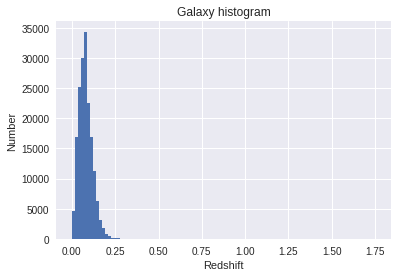

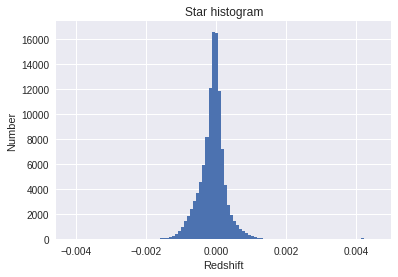

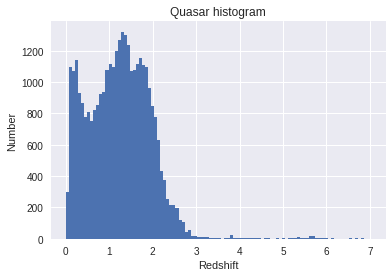

In [0]:
data = training
data['class'] = y_training
data = data[['redshift', 'class']]

data[data['class'].str.contains('GALAXY')].hist(bins=100)
plt.title('Galaxy histogram')
plt.xlabel('Redshift')
plt.ylabel('Number')
data[data['class'].str.contains('STAR')].hist(bins=100)
plt.title('Star histogram')
plt.xlabel('Redshift')
plt.ylabel('Number')
data[data['class'].str.contains('QSO')].hist(bins=100)
plt.title('Quasar histogram')
plt.xlabel('Redshift')
plt.ylabel('Number')

## Box plots per feature

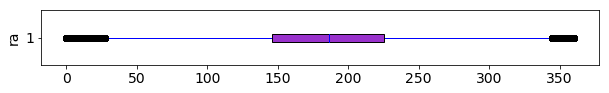

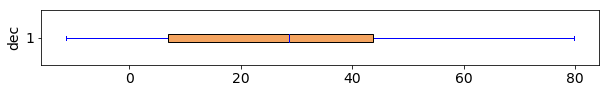

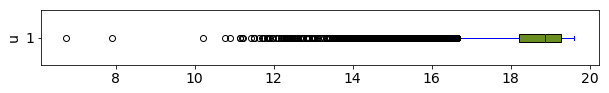

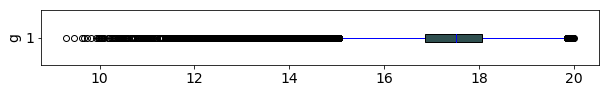

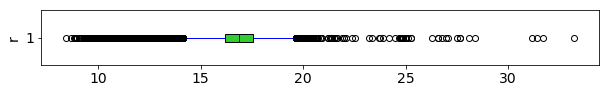

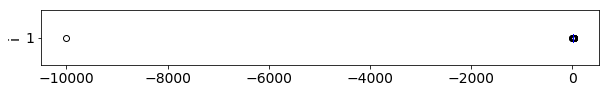

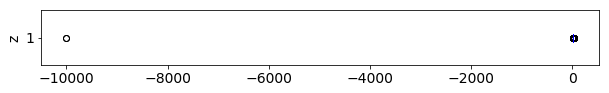

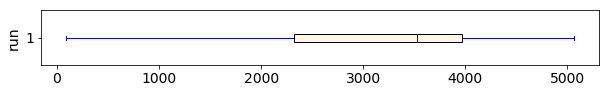

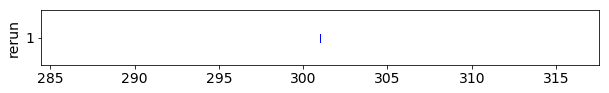

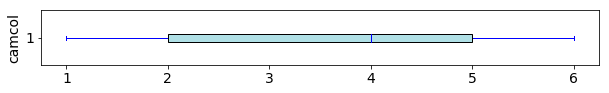

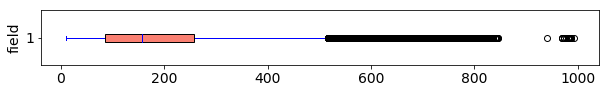

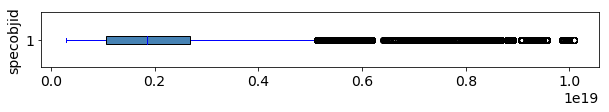

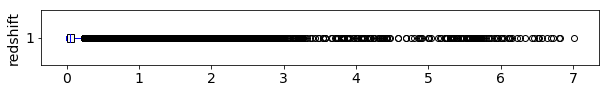

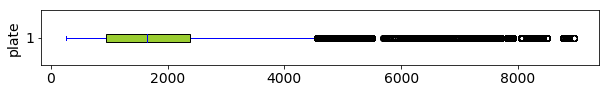

In [0]:
colors = ['#9932CC', '#F4A460', '#6B8E23', '#2F4F4F', '#32CD32', '#9370DB', '#FFE4B5', '#FDF5E6', '#EEE8AA',
          '#B0E0E6', '#FA8072', '#4682B4', '#F5F5F5', '#9ACD32']
matplotlib.rcParams.update({'font.size': 14})
for col, color in zip(training.columns.values, colors):
    fig, ax = plt.subplots(figsize=(10,1))
#     fig(figsize=(15,2))
    box = ax.boxplot(training[col], vert=False, patch_artist=True)
    box['boxes'][0].set(facecolor=color)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(box[element], color='b')
    plt.ylabel(col)

## Objects maped onto earth map

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/root/anaconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:421: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


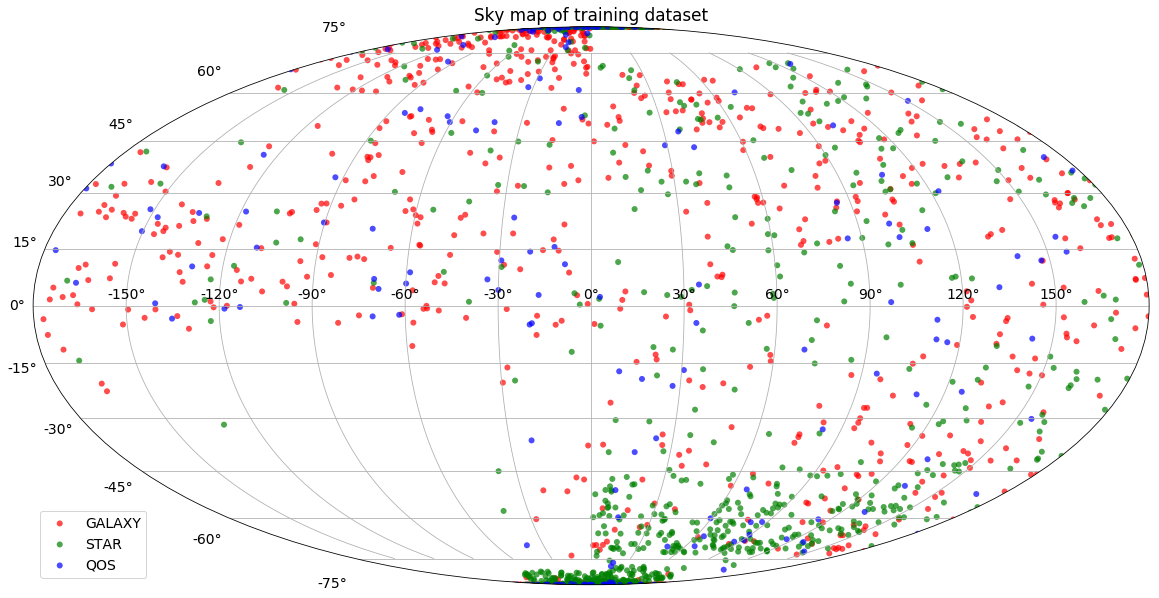

In [0]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='mollweide')
data = training[['ra', 'dec']]
data['class'] = y_training
category = [data[data['class'].str.contains('GALAXY')], 
            data[data['class'].str.contains('STAR')], 
            data[data['class'].str.contains('QSO')]]
colors = ['red', 'green', 'blue']
classes = ['GALAXY', 'STAR', 'QOS']
for cat, color, class_ in zip(category, colors, classes):
    ax.scatter(cat['ra'], cat['dec'], c=color, label=class_, alpha=0.7, edgecolors='none')
ax.legend()
ax.grid(True)
plt.title('Sky map of training dataset')
fig.savefig('sky_train_plot.pdf')

## Correlation between features on heatmap

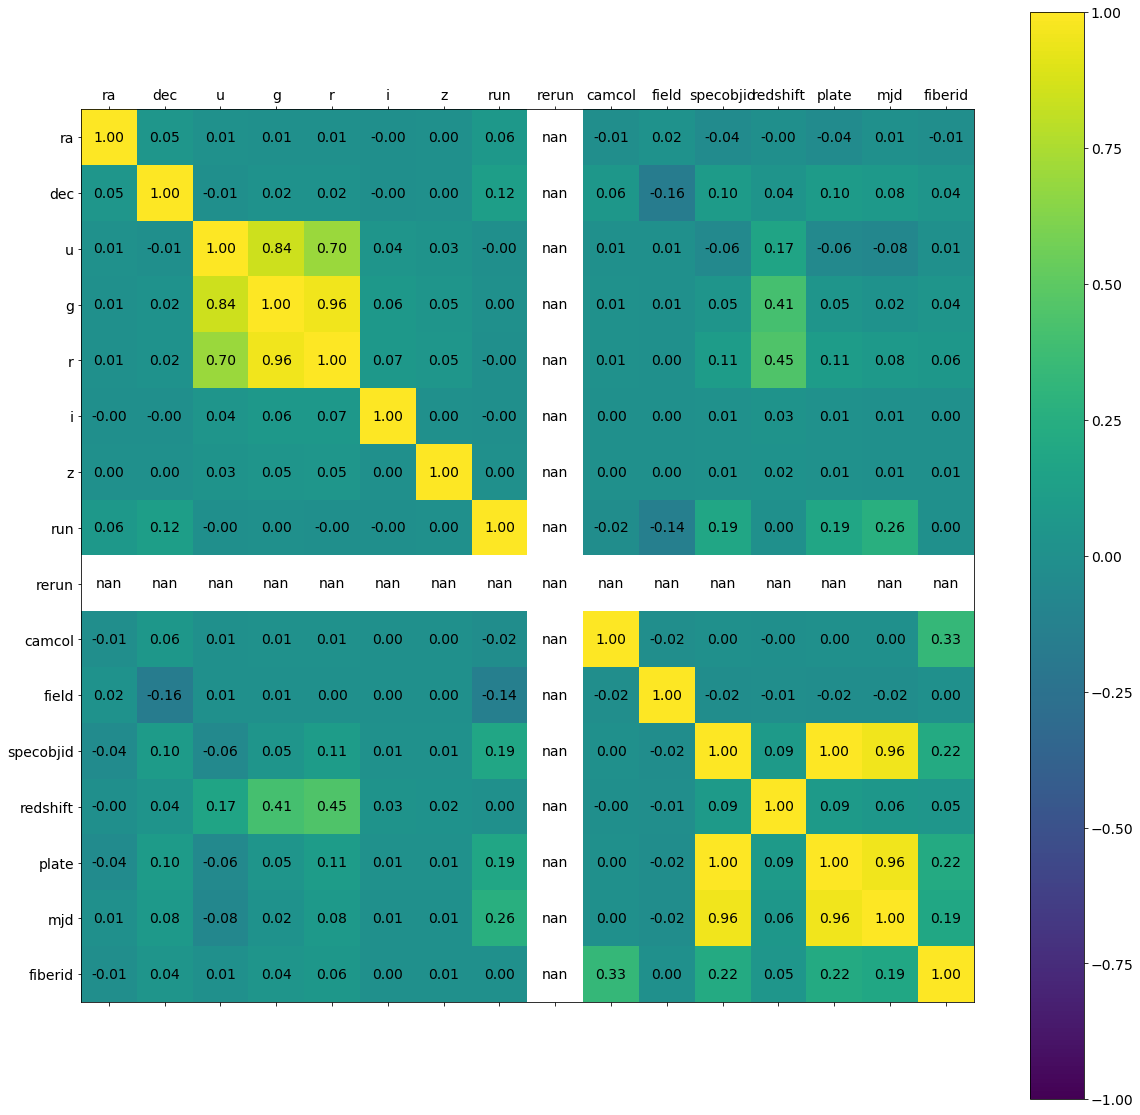

In [0]:
correlation = training.corr()
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cax = ax.matshow(correlation, vmin=-1, vmax=1, interpolation='none')
ticks = [i for i in range(training.shape[1])]
ticklabels = training.columns.values.tolist()
plt.xticks(ticks, ticklabels)
plt.yticks(ticks, ticklabels)
ax.axis('image')
# Text on the plot
for y, row in enumerate(correlation.values):
    for x, val in enumerate(row):
        ax.text(x, y, format(val, '.2f'), color='black', ha='center', va='center')   
fig.colorbar(cax)
fig.savefig('train_correlation_plot.pdf')

## Features histograms before log transform

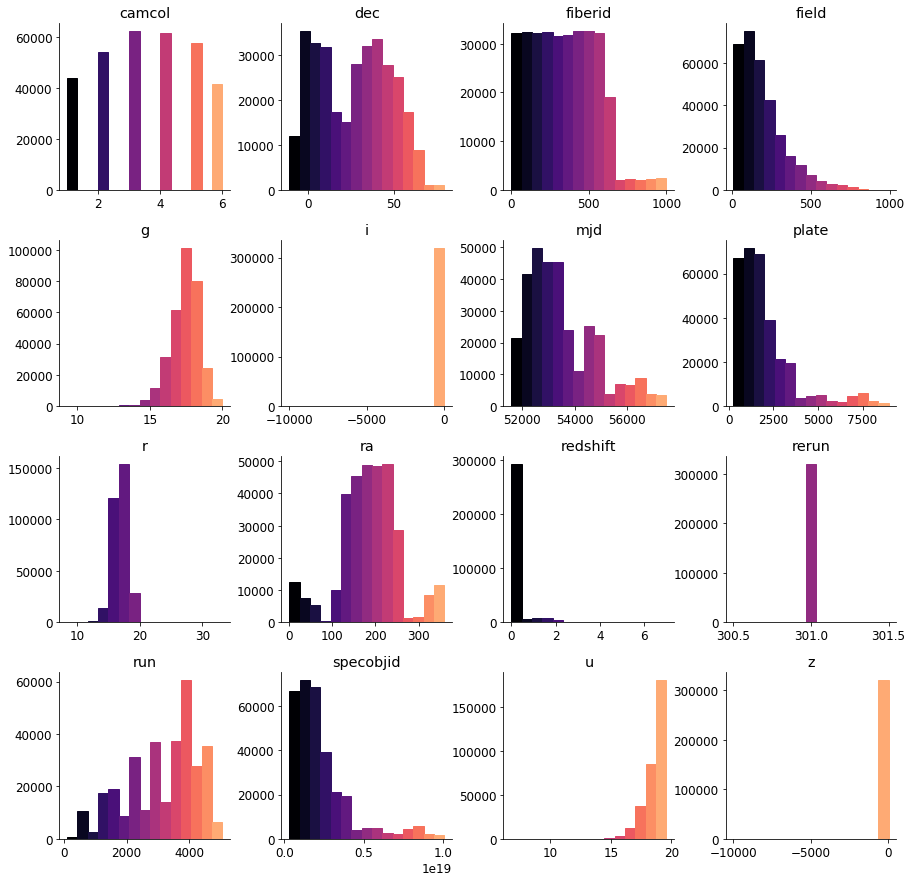

In [0]:
colors = [matplotlib.colors.rgb2hex(i) for i in plt.get_cmap('magma').colors][50:100]
colors = plt.get_cmap('magma').colors[::15]
# colors = ['#9932CC', '#F4A460', '#6B8E23', '#2F4F4F', '#32CD32', '#9370DB', '#FFE4B5', '#FDF5E6', '#EEE8AA',
#           '#B0E0E6', '#FA8072', '#4682B4', '#F5F5F5', '#9ACD32']
matplotlib.rcParams.update({'font.size': 12})
axes = training.hist(figsize=(15,15), bins=15)
for row in axes:
    for ax in row:
        ax.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        for patch, color in zip(ax.patches, colors):
            if patch.get_height() > 0:
                patch.set_color(color)

## Log transformation for particular features

In [0]:
training['specobjid'] = np.log(training['specobjid'])
training['field'] = np.log(training['field'])
training['run'] = np.log(training['run'])
training['plate'] = np.log(training['plate'])

In [0]:
valid['specobjid'] = np.log(valid['specobjid'])
valid['field'] = np.log(valid['field'])
valid['run'] = np.log(valid['run'])
valid['plate'] = np.log(valid['plate'])

In [0]:
test['specobjid'] = np.log(test['specobjid'])
test['field'] = np.log(test['field'])
test['run'] = np.log(test['run'])
test['plate'] = np.log(test['plate'])

**After log transform**

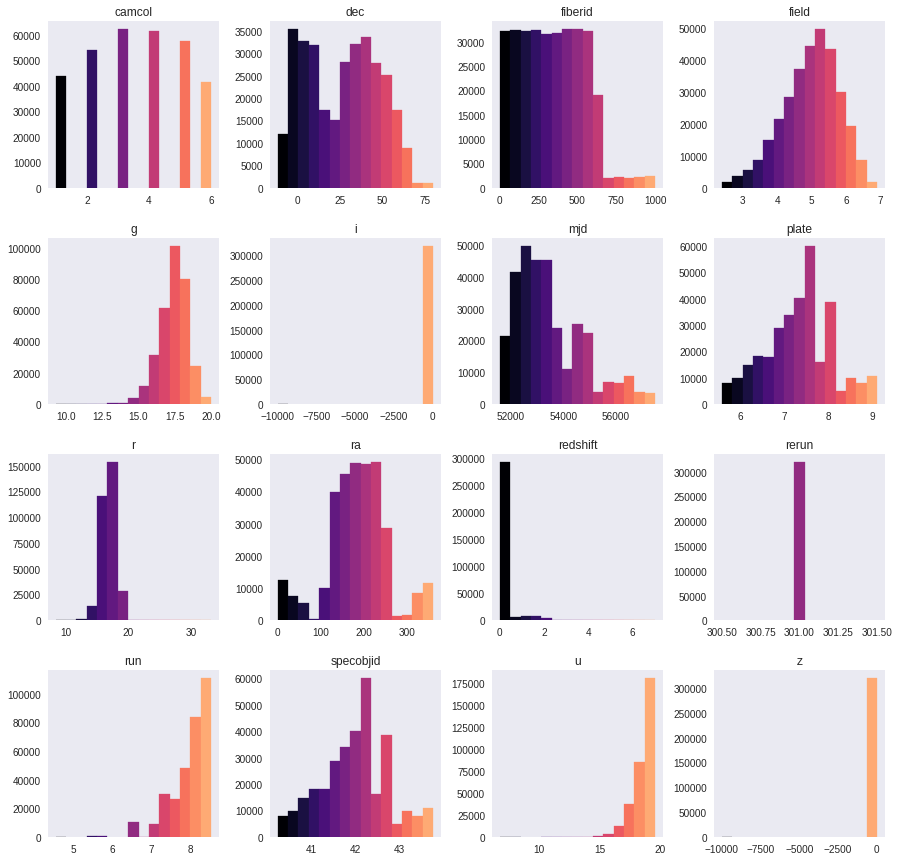

In [0]:
colors = [matplotlib.colors.rgb2hex(i) for i in plt.get_cmap('magma').colors][50:100]
colors = plt.get_cmap('magma').colors[::15]
# colors = ['#9932CC', '#F4A460', '#6B8E23', '#2F4F4F', '#32CD32', '#9370DB', '#FFE4B5', '#FDF5E6', '#EEE8AA',
#           '#B0E0E6', '#FA8072', '#4682B4', '#F5F5F5', '#9ACD32']
matplotlib.rcParams.update({'font.size': 12})
axes = training.hist(figsize=(15,15), bins=15)
for row in axes:
    for ax in row:
        ax.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        for patch, color in zip(ax.patches, colors):
            if patch.get_height() > 0:
                patch.set_color(color)

## Drop constant feature

In [0]:
training = training.drop(['rerun'], axis=1)

In [0]:
valid = valid.drop(['rerun'], axis=1)

In [0]:
test = test.drop(['rerun'], axis=1)

# Cross-Validation ML algorithms

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [0]:
try:
    from xgboost import XGBClassifier
except ModuleNotFoundError:
    import sys
    !conda install --yes --prefix {sys.prefix} -c conda-forge xgboost

In [0]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression(n_jobs=-1))])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier(n_jobs=-1))])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC(probability=True))])))
pipelines.append(('AB', AdaBoostClassifier()))
pipelines.append(('GB', GradientBoostingClassifier()))
pipelines.append(('RF', RandomForestClassifier(n_jobs=-1)))
pipelines.append(('ET', ExtraTreesClassifier(n_jobs=-1)))
pipelines.append(('XGB', XGBClassifier(n_jobs=-1)))

In [0]:
import time
num_fold = 5
seed = 7
scoring_1 = 'accuracy'
scoring_2 = 'neg_log_loss'
results = []
names = []
times = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_fold, random_state=seed)
    # accuracy
    start = time.time()
    cv_results_acc = cross_val_score(model, 
                                     training, 
                                     y_training, 
                                     cv=kfold, 
                                     scoring=scoring_1, 
                                     n_jobs=-1)
    end = time.time()
    results.append(cv_results_acc)
    names.append("Accuracy CV {}".format(name))
    times.append(end-start)
    msg = "{}- Accuracy mean: {} std: ({}) Compute time: {}".format(name, 
                                                                    cv_results_acc.mean(), 
                                                                    cv_results_acc.std(),
                                                                    end-start)
    print(msg)
    # neg_log_loss
    start = time.time()
    cv_results_nll = cross_val_score(model, 
                                     training, 
                                     y_training, 
                                     cv=kfold, 
                                     scoring=scoring_2, 
                                     n_jobs=-1)
    end = time.time()
    results.append(cv_results_nll)
    names.append("Neg Log Loss CV {}".format(name))
    times.append(end-start)
    msg = "{}- Neg_log_loss mean: {} std: ({}) Compute time: {}".format(name, 
                                                                        cv_results_nll.mean(), 
                                                                        cv_results_nll.std(),
                                                                        end-start)
    print(msg)

ScaledLR- Accuracy mean: 0.9667625 std: (0.00214583990694785) Compute time: 53.079999685287476
ScaledLR- Neg_log_loss mean: -0.15731852261195864 std: (0.009102487863394987) Compute time: 53.009464502334595
ScaledLDA- Accuracy mean: 0.8507125 std: (0.0172) Compute time: 3.311737537384033
ScaledLDA- Neg_log_loss mean: -0.4731602195141448 std: (0.03701910020283535) Compute time: 3.330390214920044
ScaledKNN- Accuracy mean: 0.9113062500000002 std: (0.0056429885975872816) Compute time: 56.38602948188782
ScaledKNN- Neg_log_loss mean: -1.0899416968480087 std: (0.05823675227101411) Compute time: 57.82075357437134
ScaledCART- Accuracy mean: 0.9879374999999999 std: (0.00041446030419087395) Compute time: 12.228512525558472
ScaledCART- Neg_log_loss mean: -0.416516056587378 std: (0.016564918550182727) Compute time: 12.40589165687561
ScaledNB- Accuracy mean: 0.925615625 std: (0.022826726300408277) Compute time: 1.166536808013916
ScaledNB- Neg_log_loss mean: -0.33550706330862523 std: (0.05299302944797

## Store all CV results into pandas dataframe

In [0]:
models_score = pd.DataFrame(columns=["Scoring", "Model", "Mean", "Std", "Time"], data=np.zeros((len(pipelines)*2,5)))

In [0]:
for i, (name, result, time_) in enumerate(zip(names, results, times)):
    if i % 2 == 0:
        models_score['Scoring'][i] = 'Accuracy'
    else:
        models_score['Scoring'][i] = 'Neg Log Loss'
    models_score['Model'][i] = name.split("CV")[-1]
    models_score['Mean'][i] = result.mean()
    models_score['Std'][i] = result.std()
    models_score['Time'][i] = time_

In [0]:
models_score

,Scoring,Model,Mean,Std,Time
0,Accuracy,ScaledLR,0.966762,0.002146,53.080000
1,Neg Log Loss,ScaledLR,-0.157319,0.009102,53.009465
2,Accuracy,ScaledLDA,0.850712,0.017200,3.311738
3,Neg Log Loss,ScaledLDA,-0.473160,0.037019,3.330390
4,Accuracy,ScaledKNN,0.911306,0.005643,56.386029
5,Neg Log Loss,ScaledKNN,-1.089942,0.058237,57.820754
6,Accuracy,ScaledCART,0.987937,0.000414,12.228513
7,Neg Log Loss,ScaledCART,-0.416516,0.016565,12.405892
8,Accuracy,ScaledNB,0.925616,0.022827,1.166537
9,Neg Log Loss,ScaledNB,-0.335507,0.052993,1.370200


## Plot training, scoring times and accuracy per algorithm

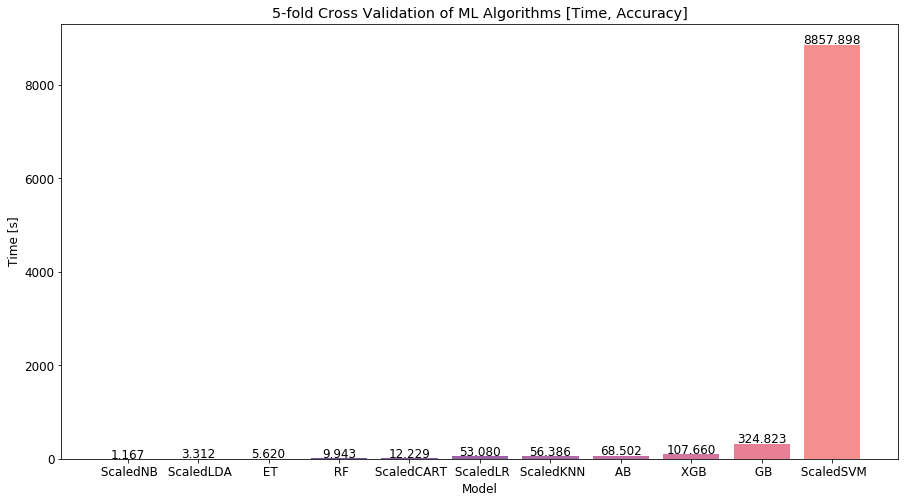

In [0]:
colors = plt.get_cmap('magma').colors[::17]
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.bar(models_score[models_score['Scoring'] == 'Accuracy'].sort_values(by=['Time'])['Model'], models_score[models_score['Scoring'] == 'Accuracy'].sort_values(by=['Time'])['Time'], color=colors, alpha=0.7)
ax.set_xlabel('Model')
ax.set_ylabel('Time [s]')
plt.title('5-fold Cross Validation of ML Algorithms [Time, Accuracy]')
for i, rect in enumerate(models_score[models_score['Scoring'] == 'Accuracy'].sort_values(by=['Time'])['Time']):
    ax.text(i, rect+10, '{:.3f}'.format(rect), ha='center')

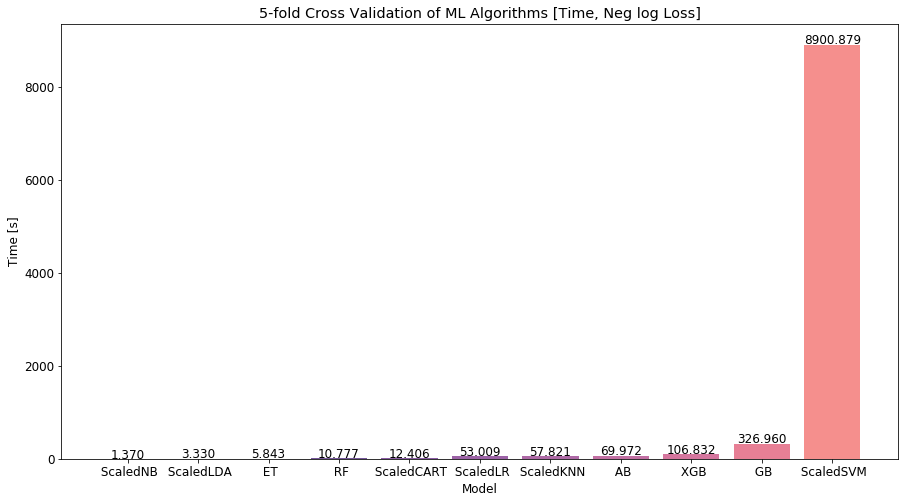

In [0]:
colors = plt.get_cmap('magma').colors[::17]
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.bar(models_score[models_score['Scoring'] == 'Neg Log Loss'].sort_values(by=['Time'])['Model'], models_score[models_score['Scoring'] == 'Neg Log Loss'].sort_values(by=['Time'])['Time'], color=colors, alpha=0.7)
ax.set_xlabel('Model')
ax.set_ylabel('Time [s]')
plt.title('5-fold Cross Validation of ML Algorithms [Time, Neg log Loss]')
for i, rect in enumerate(models_score[models_score['Scoring'] == 'Neg Log Loss'].sort_values(by=['Time'])['Time']):
    ax.text(i, rect+10, '{:.3f}'.format(rect), ha='center')

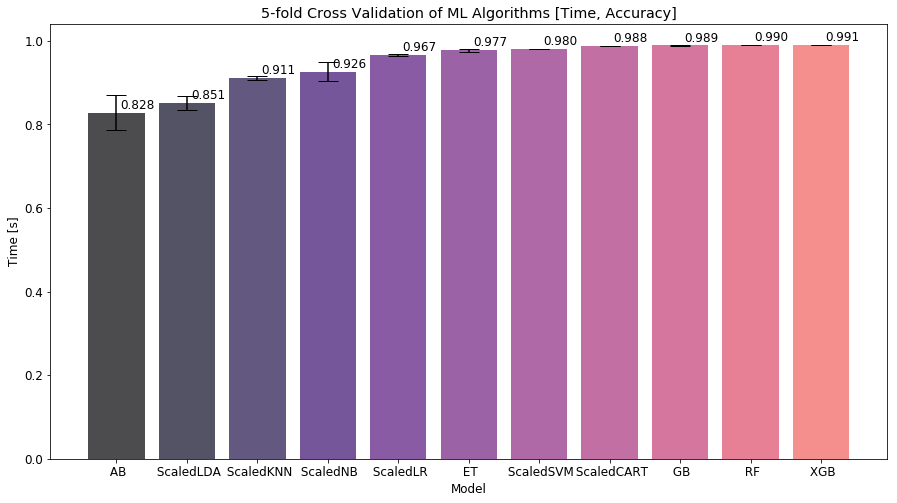

In [0]:
colors = plt.get_cmap('magma').colors[::17]
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.bar(models_score[models_score['Scoring'] == 'Accuracy'].sort_values(by=['Mean'])['Model'], 
       models_score[models_score['Scoring'] == 'Accuracy'].sort_values(by=['Mean'])['Mean'],
       color=colors,
       alpha=0.7,
       yerr=models_score[models_score['Scoring'] == 'Accuracy'].sort_values(by=['Mean'])['Std'], capsize=10)
ax.set_xlabel('Model')
ax.set_ylabel('Time [s]')
plt.title('5-fold Cross Validation of ML Algorithms [Time, Accuracy]')
for i, rect in enumerate(models_score[models_score['Scoring'] == 'Accuracy'].sort_values(by=['Mean'])['Mean']):
    ax.text(i+0.3, rect+0.01, '{:.3f}'.format(rect), ha='center')

## Plot neg log loss per algorithm

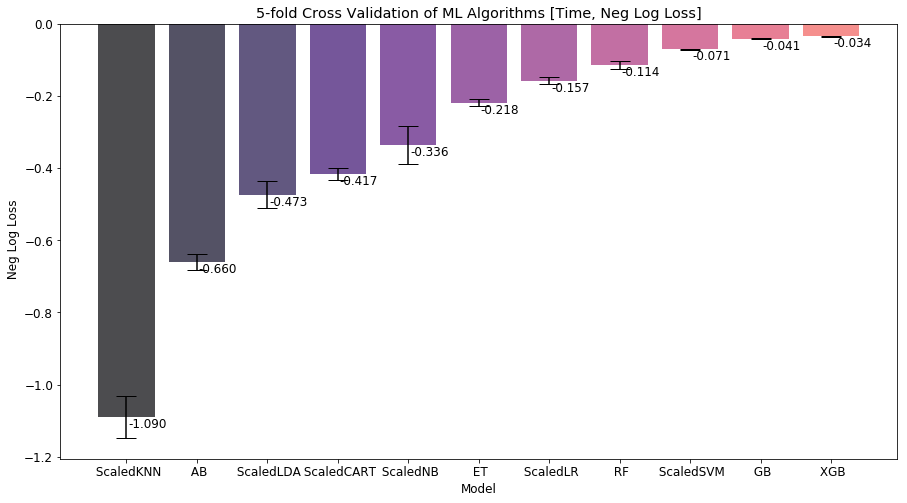

In [0]:
colors = plt.get_cmap('magma').colors[::17]
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.bar(models_score[models_score['Scoring'] == 'Neg Log Loss'].sort_values(by=['Mean'])['Model'], 
       models_score[models_score['Scoring'] == 'Neg Log Loss'].sort_values(by=['Mean'])['Mean'],
       color=colors,
       alpha=0.7,
       yerr=models_score[models_score['Scoring'] == 'Neg Log Loss'].sort_values(by=['Mean'])['Std'], capsize=10)
ax.set_xlabel('Model')
ax.set_ylabel(' Neg Log Loss')
plt.title('5-fold Cross Validation of ML Algorithms [Time, Neg Log Loss]')
for i, rect in enumerate(models_score[models_score['Scoring'] == 'Neg Log Loss'].sort_values(by=['Mean'])['Mean']):
    ax.text(i+0.3, rect-0.03, '{:.3f}'.format(rect), ha='center')

## Box plots per algorithm

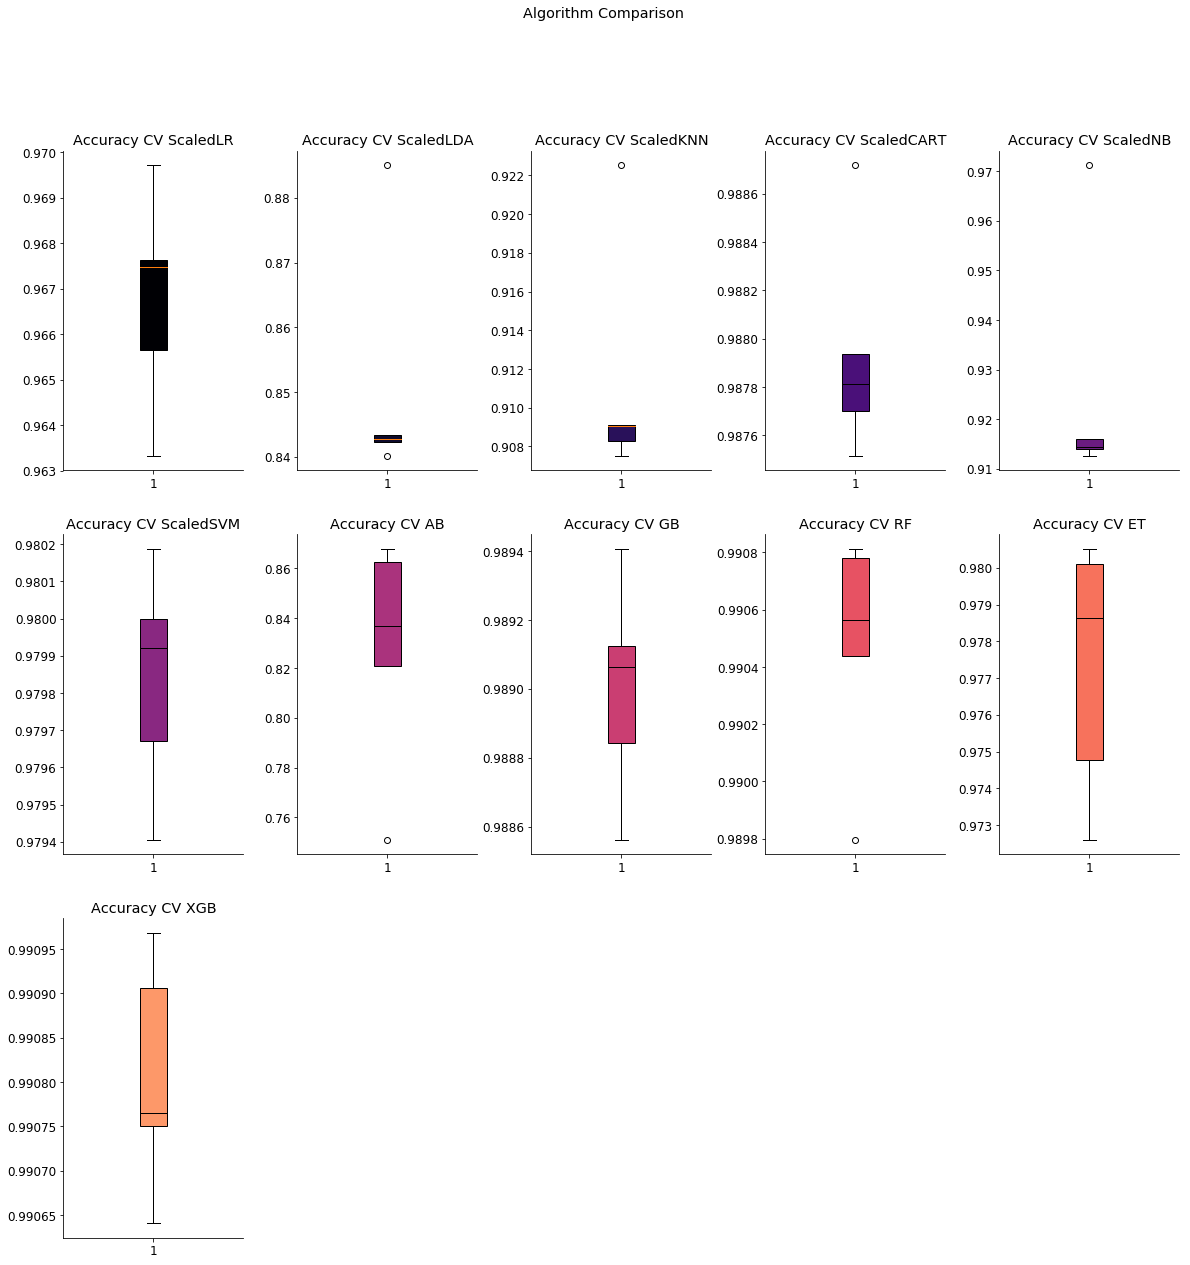

In [0]:
colors = plt.get_cmap('magma').colors[::10]
fig = plt.figure(figsize=(20,20))
fig.suptitle('Algorithm Comparison')
for i, (name, result, time_, color) in enumerate(zip(names, results, times, colors)):
    if i % 2 == 0:
        ax = plt.subplot(3,5,i/2+1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        patch = ax.boxplot(result, patch_artist=True)
        patch['boxes'][0].set(facecolor=color)
        if i > 4:
            plt.setp(patch['medians'], color='#000000')
        plt.title(name)
        i += 1
plt.subplots_adjust(wspace=0.3)

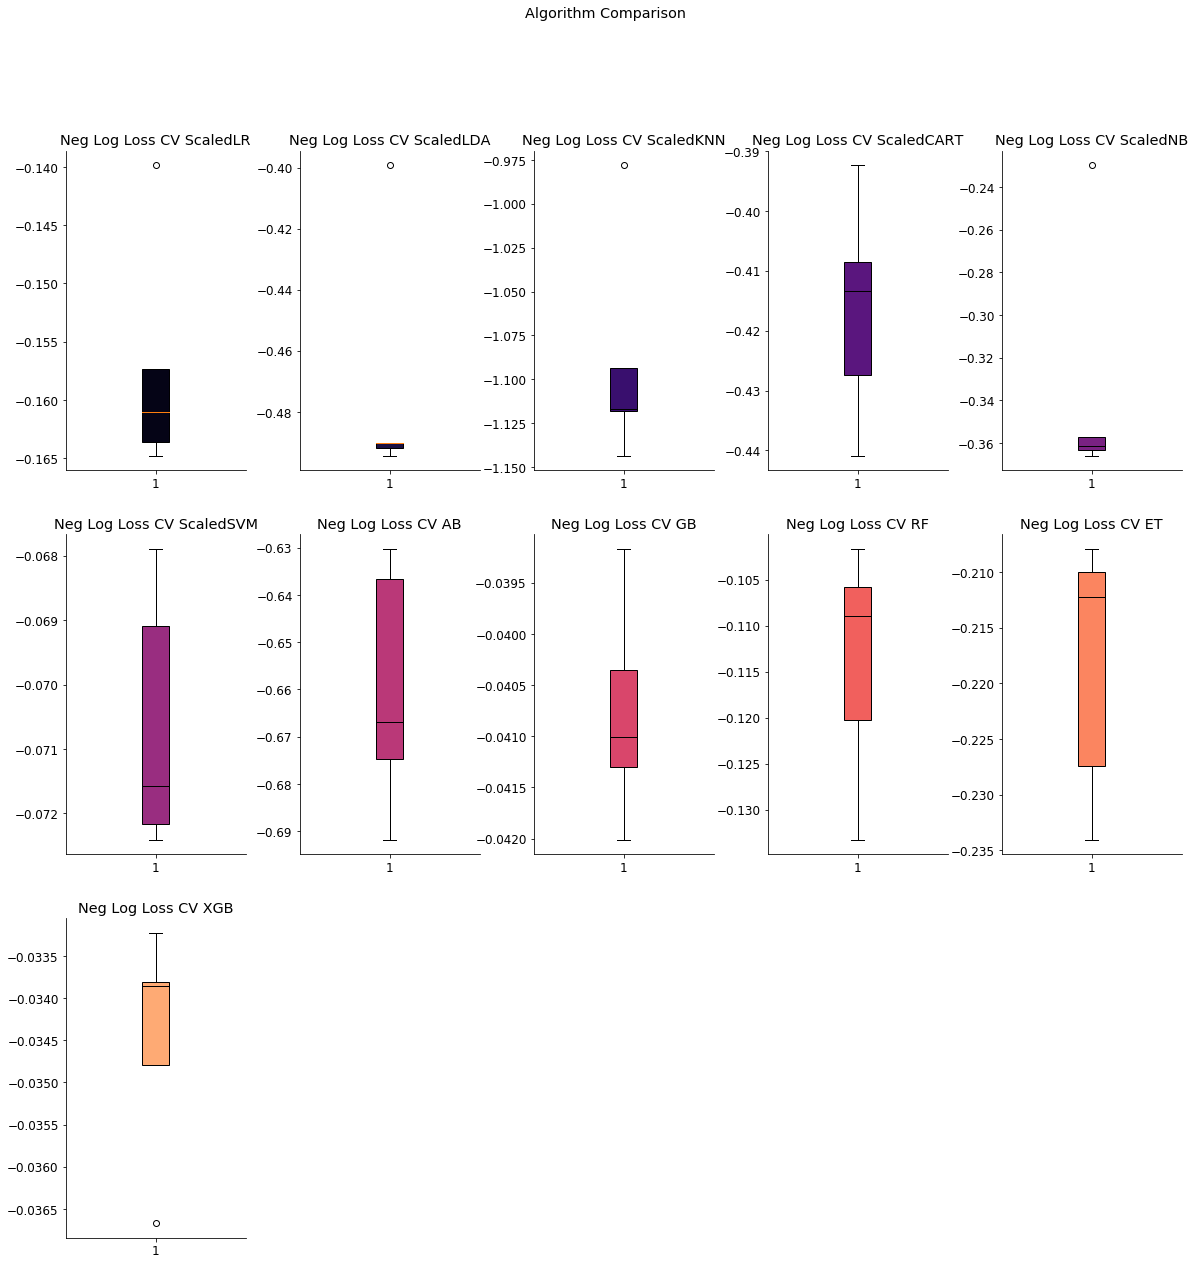

In [0]:
colors = plt.get_cmap('magma').colors[::10]
fig = plt.figure(figsize=(20,20))
fig.suptitle('Algorithm Comparison')
for i, (name, result, time_, color) in enumerate(zip(names, results, times, colors)):
    if i % 2 != 0:
        ax = plt.subplot(3,5,i/2+1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        patch = ax.boxplot(result, patch_artist=True)
        patch['boxes'][0].set(facecolor=color)
        if i > 4:
            plt.setp(patch['medians'], color='#000000')
        plt.title(name)
        i += 1
plt.subplots_adjust(wspace=0.3)

# Logistic Regression Log Loss

In [0]:
C = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

num_fold = 5
seed = 7
scoring = 'accuracy'
scoring_2 = 'neg_log_loss'
param_grid = {'LR__C': C, "LR__solver": solver}
print(pipelines[0][0])
model = pipelines[0][1] # Logistic Regression model
kfold = KFold(n_splits=num_fold, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring_2, cv=kfold)
grid_result = grid.fit(training, y_training)
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format(mean, stdev, param))
pd.DataFrame(grid_result.cv_results_).to_csv('LR_log_loss_scores.csv')
grid_result = pd.read_csv('LR_log_loss_scores.csv')

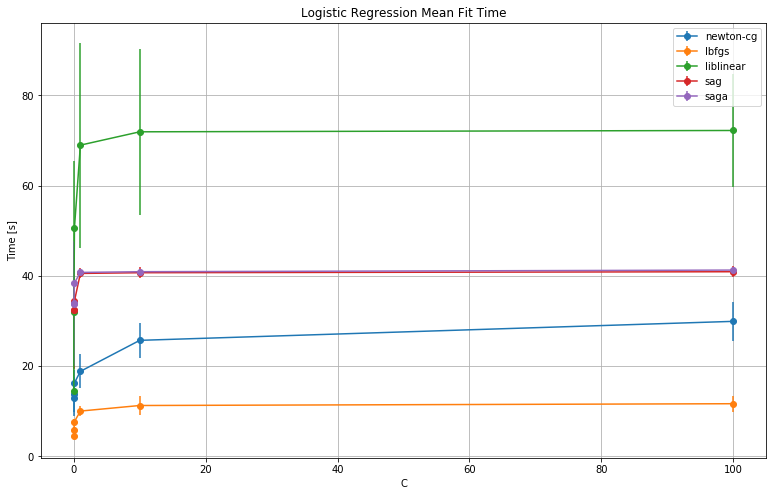

In [0]:
import ast
def fill_params(parameters, alg, t, p, s):
    try:
        parameters['{}'.format(alg)]['time'].append(t)
        parameters['{}'.format(alg)]['c'].append(p['LR__C'])
        parameters['{}'.format(alg)]['std'].append(s)
    except KeyError:
        parameters['{}'.format(alg)] = {'time': [], 'c': [], 'std': []}
        parameters['{}'.format(alg)]['time'].append(t)
        parameters['{}'.format(alg)]['c'].append(p['LR__C'])
        parameters['{}'.format(alg)]['std'].append(s)

mean_fit_time = grid_result['mean_fit_time']
std_fit_time = grid_result['std_fit_time']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_fit_time, params, std_fit_time):
    p = ast.literal_eval(p)
    if p['LR__solver'] == 'newton-cg':
        fill_params(parameters, 'newton-cg', t, p, s)
    elif p['LR__solver'] == 'lbfgs':
        fill_params(parameters, 'lbfgs', t, p, s)
    elif p['LR__solver'] == 'liblinear':
        fill_params(parameters, 'liblinear', t, p, s)
    elif p['LR__solver'] == 'sag':
        fill_params(parameters, 'sag', t, p, s)
    else:
        fill_params(parameters, 'saga', t, p, s)

fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('Logistic Regression Mean Fit Time')
for key, value in parameters.items():
    ax.errorbar(value['c'], value['time'], value['std'], label=key, marker='o', linestyle='-')
ax.set_ylabel('Time [s]')
ax.set_xlabel('C')
ax.grid(True)
ax.legend()

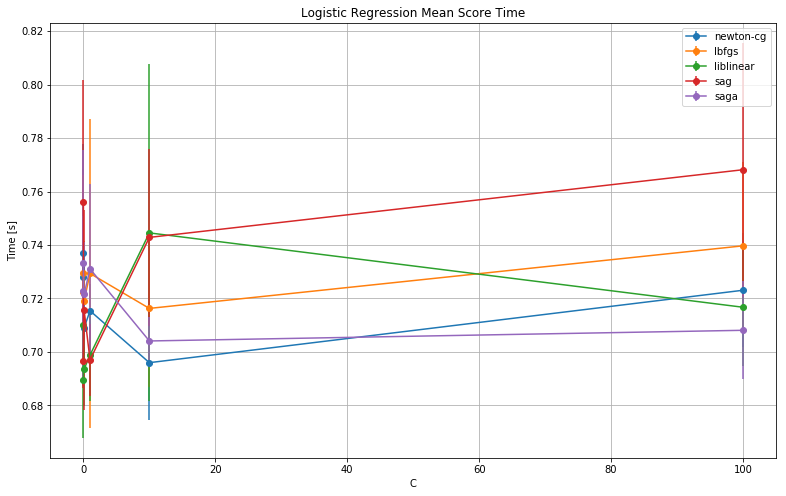

In [0]:
import ast
def fill_params(parameters, alg, t, p, s):
    try:
        parameters['{}'.format(alg)]['time'].append(t)
        parameters['{}'.format(alg)]['c'].append(p['LR__C'])
        parameters['{}'.format(alg)]['std'].append(s)
    except KeyError:
        parameters['{}'.format(alg)] = {'time': [], 'c': [], 'std': []}
        parameters['{}'.format(alg)]['time'].append(t)
        parameters['{}'.format(alg)]['c'].append(p['LR__C'])
        parameters['{}'.format(alg)]['std'].append(s)

mean_score_time = grid_result['mean_score_time']
std_score_time = grid_result['std_score_time']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_score_time, params, std_score_time):
    p = ast.literal_eval(p)
    if p['LR__solver'] == 'newton-cg':
        fill_params(parameters, 'newton-cg', t, p, s)
    elif p['LR__solver'] == 'lbfgs':
        fill_params(parameters, 'lbfgs', t, p, s)
    elif p['LR__solver'] == 'liblinear':
        fill_params(parameters, 'liblinear', t, p, s)
    elif p['LR__solver'] == 'sag':
        fill_params(parameters, 'sag', t, p, s)
    else:
        fill_params(parameters, 'saga', t, p, s)

fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('Logistic Regression Mean Score Time')
for key, value in parameters.items():
    ax.errorbar(value['c'], value['time'], value['std'], label=key, marker='o', linestyle='-')
ax.set_ylabel('Time [s]')
ax.set_xlabel('C')
ax.grid(True)
ax.legend()

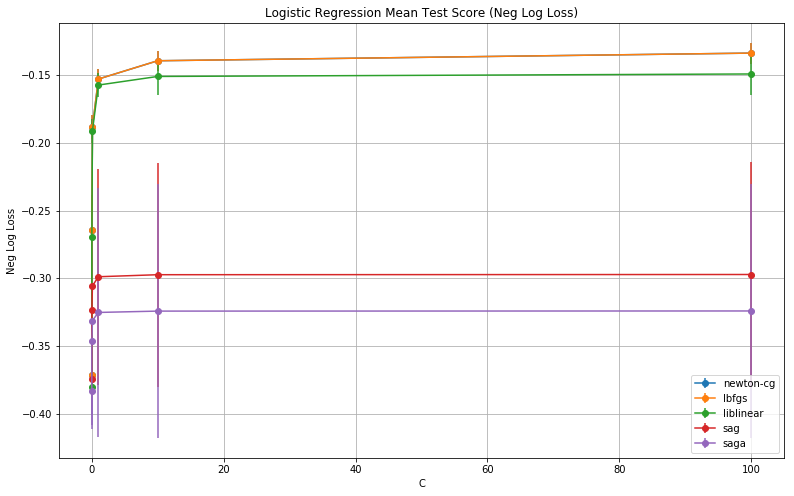

In [0]:
import ast
def fill_params(parameters, alg, t, p, s):
    try:
        parameters['{}'.format(alg)]['score'].append(t)
        parameters['{}'.format(alg)]['c'].append(p['LR__C'])
        parameters['{}'.format(alg)]['std'].append(s)
    except KeyError:
        parameters['{}'.format(alg)] = {'score': [], 'c': [], 'std': []}
        parameters['{}'.format(alg)]['score'].append(t)
        parameters['{}'.format(alg)]['c'].append(p['LR__C'])
        parameters['{}'.format(alg)]['std'].append(s)

mean_test_score = grid_result['mean_test_score']
std_test_score = grid_result['std_test_score']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_test_score, params, std_test_score):
    p = ast.literal_eval(p)
    if p['LR__solver'] == 'newton-cg':
        fill_params(parameters, 'newton-cg', t, p, s)
    elif p['LR__solver'] == 'lbfgs':
        fill_params(parameters, 'lbfgs', t, p, s)
    elif p['LR__solver'] == 'liblinear':
        fill_params(parameters, 'liblinear', t, p, s)
    elif p['LR__solver'] == 'sag':
        fill_params(parameters, 'sag', t, p, s)
    else:
        fill_params(parameters, 'saga', t, p, s)

fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('Logistic Regression Mean Test Score (Neg Log Loss)')
for key, value in parameters.items():
    ax.errorbar(value['c'], value['score'], value['std'], label=key, marker='o', linestyle='-')
ax.set_ylabel('Neg Log Loss')
ax.set_xlabel('C')
ax.grid(True)
ax.legend()

# Logistic Regression Accuracy

In [0]:
C = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

num_fold = 5
seed = 7
scoring = 'accuracy'
scoring_2 = 'neg_log_loss'
param_grid = {'LR__C': C, "LR__solver": solver}
print(pipelines[0][0])
model = pipelines[0][1] # Logistic Regression model
kfold = KFold(n_splits=num_fold, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(training, y_training)
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format(mean, stdev, param))
pd.DataFrame(grid_result.cv_results_).to_csv('LR_acc.csv')
grid_result = pd.read_csv('LR_acc.csv')

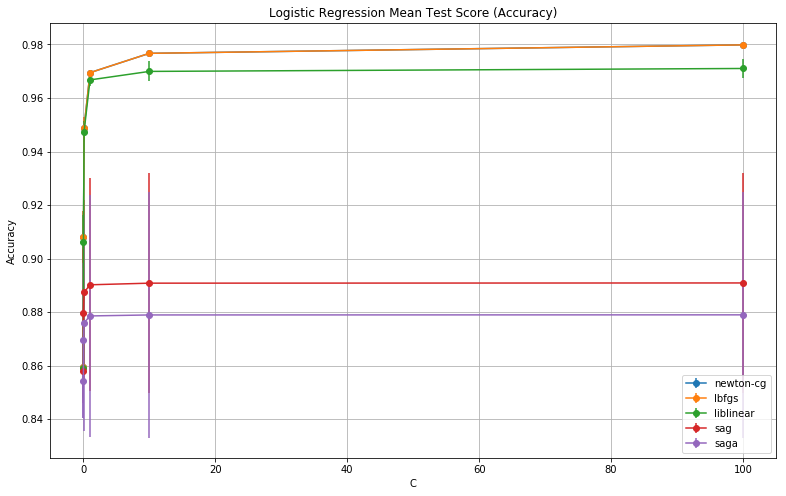

In [0]:
import ast
def fill_params(parameters, alg, t, p, s):
    try:
        parameters['{}'.format(alg)]['score'].append(t)
        parameters['{}'.format(alg)]['c'].append(p['LR__C'])
        parameters['{}'.format(alg)]['std'].append(s)
    except KeyError:
        parameters['{}'.format(alg)] = {'score': [], 'c': [], 'std': []}
        parameters['{}'.format(alg)]['score'].append(t)
        parameters['{}'.format(alg)]['c'].append(p['LR__C'])
        parameters['{}'.format(alg)]['std'].append(s)

mean_test_score = grid_result['mean_test_score']
std_test_score = grid_result['std_test_score']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_test_score, params, std_test_score):
    p = ast.literal_eval(p)
    if p['LR__solver'] == 'newton-cg':
        fill_params(parameters, 'newton-cg', t, p, s)
    elif p['LR__solver'] == 'lbfgs':
        fill_params(parameters, 'lbfgs', t, p, s)
    elif p['LR__solver'] == 'liblinear':
        fill_params(parameters, 'liblinear', t, p, s)
    elif p['LR__solver'] == 'sag':
        fill_params(parameters, 'sag', t, p, s)
    else:
        fill_params(parameters, 'saga', t, p, s)

fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('Logistic Regression Mean Test Score (Accuracy)')
for key, value in parameters.items():
    ax.errorbar(value['c'], value['score'], value['std'], label=key, marker='o', linestyle='-')
ax.set_ylabel('Accuracy')
ax.set_xlabel('C')
ax.grid(True)
ax.legend()

In [0]:
from sklearn.metrics import roc_auc_score
model = Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression(n_jobs=-1))])
# model.fit(training, y_training)
# print('after training')
predictions = model.predict(test.values)
print('after evaluate')
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y_test = encoder.transform(y_test)
roc = roc_auc_score(encoded_Y_test, predictions)
print(roc)

# pipelines = []
# pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression(n_jobs=-1))])))
# pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])))
# pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier(n_jobs=-1))])))
# pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])))
# pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
# pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC(probability=True))])))
# pipelines.append(('AB', AdaBoostClassifier()))
# pipelines.append(('GB', GradientBoostingClassifier()))
# pipelines.append(('RF', RandomForestClassifier(n_jobs=-1)))
# pipelines.append(('ET', ExtraTreesClassifier(n_jobs=-1)))
# pipelines.append(('XGB', XGBClassifier(n_jobs=-1)))

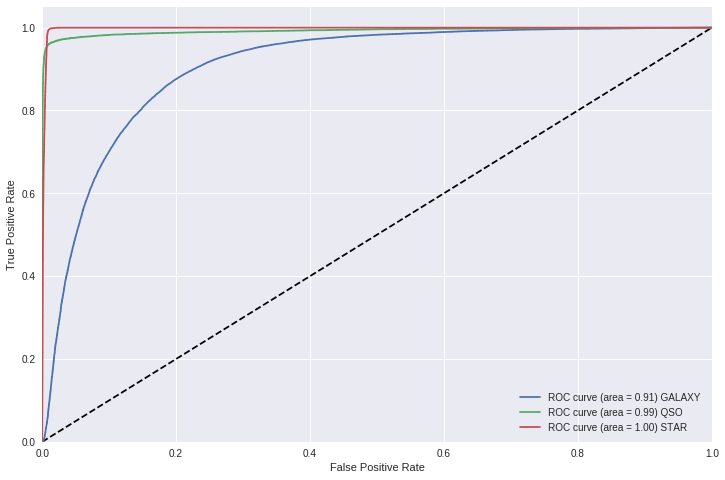

In [0]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc

model = Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])

y = label_binarize(encoded_Y_test, classes=[0,1,2])
n_classes = 3

clf = OneVsRestClassifier(model)
y_score = clf.fit(training, y_training).decision_function(test.values)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
plt.figure(figsize=(12,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for i in range(n_classes):
    if i == 0:
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = {:.2f}) {} '.format(roc_auc[i], 'GALAXY'))
    elif i == 1:
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = {:.2f}) {} '.format(roc_auc[i], 'QSO'))
    else:
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = {:.2f}) {} '.format(roc_auc[i], 'STAR'))
plt.legend(loc="lower right")

# k-NN log loss

In [0]:
n_neighbors  = [3, 7, 11, 15, 19, 23, 27]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'chebyshev']
# http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
# http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html
                                                         
num_fold = 5
seed = 7
scoring = 'neg_log_loss'
param_grid = {'KNN__n_neighbors': n_neighbors}
print(pipelines[2][0])
model = pipelines[2][1] # k-NN model
kfold = KFold(n_splits=num_fold, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(training, y_training)
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format(mean, stdev, param))
pd.DataFrame(grid_result.cv_results_).to_csv('KNN_neg_log_loss_m.csv')
grid_result = pd.read_csv('KNN_neg_log_loss_m.csv')

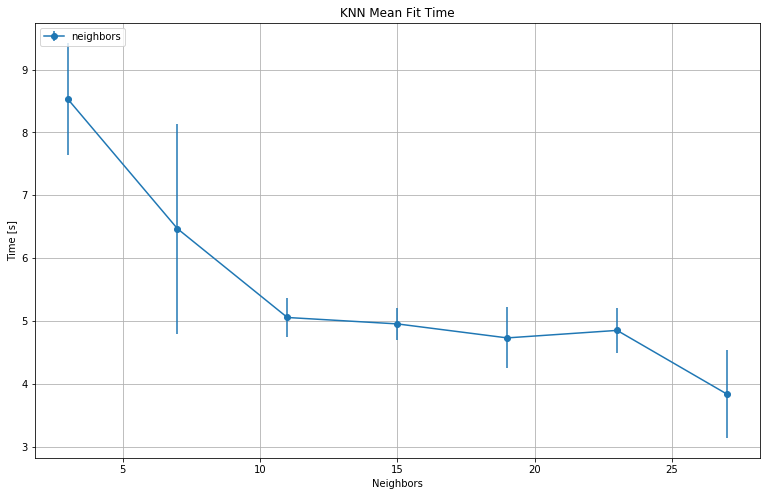

In [0]:
import ast
mean_fit_time = grid_result['mean_fit_time']
std_fit_time = grid_result['std_fit_time']
params = grid_result['params']
parameters = {'n': []}
for p in params:
    p = ast.literal_eval(p)
    parameters['n'].append(p['KNN__n_neighbors'])
        
fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('KNN Mean Fit Time')
ax.errorbar(parameters['n'], mean_fit_time, std_fit_time, label='neighbors', marker='o', linestyle='-')
ax.set_ylabel('Time [s]')
ax.set_xlabel('Neighbors')
ax.grid(True)
ax.legend(loc='upper left')

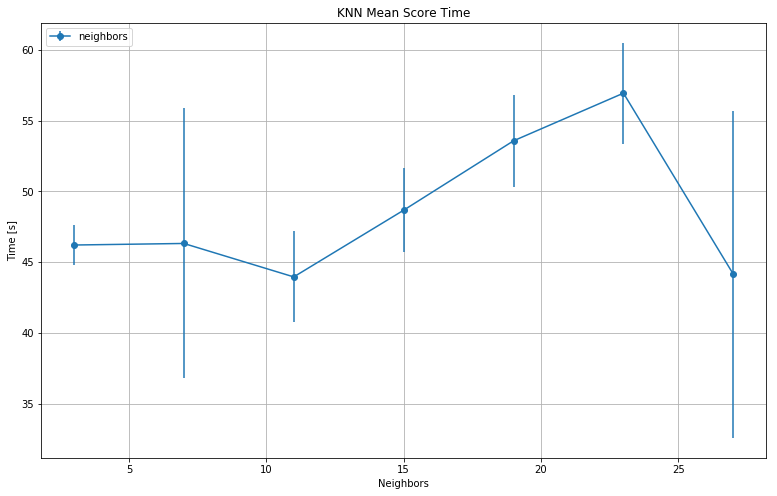

In [0]:
import ast
mean_score_time = grid_result['mean_score_time']
std_score_time = grid_result['std_score_time']
params = grid_result['params']
parameters = {'n': []}
for p in params:
    p = ast.literal_eval(p)
    parameters['n'].append(p['KNN__n_neighbors'])
        
fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('KNN Mean Score Time')
ax.errorbar(parameters['n'], mean_score_time, std_score_time, label='neighbors', marker='o', linestyle='-')
ax.set_ylabel('Time [s]')
ax.set_xlabel('Neighbors')
ax.grid(True)
ax.legend(loc='upper left')

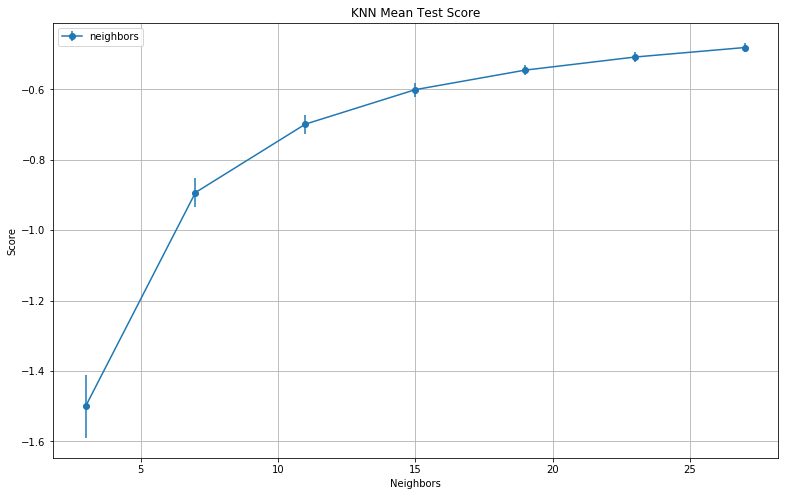

In [0]:
import ast
mean_test_score = grid_result['mean_test_score']
std_test_score = grid_result['std_test_score']
params = grid_result['params']
parameters = {'n': []}
for p in params:
    p = ast.literal_eval(p)
    parameters['n'].append(p['KNN__n_neighbors'])
        
fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('KNN Mean Test Score')
ax.errorbar(parameters['n'], mean_test_score, std_test_score, label='neighbors', marker='o', linestyle='-')
ax.set_ylabel('Score')
ax.set_xlabel('Neighbors')
ax.grid(True)
ax.legend(loc='upper left')

# k-NN acc

In [0]:
n_neighbors  = [3, 7, 11, 15, 19, 23, 27]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'chebyshev']
# http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
# http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html
                                                         
num_fold = 5
seed = 7
scoring = 'accuracy'
param_grid = {'KNN__n_neighbors': n_neighbors}
print(pipelines[2][0])
model = pipelines[2][1] # k-NN model
kfold = KFold(n_splits=num_fold, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(training, y_training)
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format(mean, stdev, param))
pd.DataFrame(grid_result.cv_results_).to_csv('KNN_acc.csv')
grid_result = pd.read_csv('KNN_acc.csv')

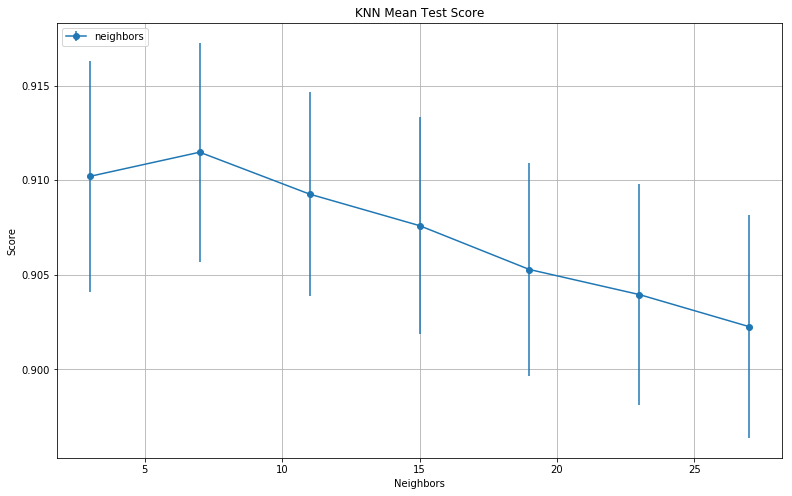

In [0]:
import ast
mean_test_score = grid_result['mean_test_score']
std_test_score = grid_result['std_test_score']
params = grid_result['params']
parameters = {'n': []}
for p in params:
    p = ast.literal_eval(p)
    parameters['n'].append(p['KNN__n_neighbors'])
        
fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('KNN Mean Test Score')
ax.errorbar(parameters['n'], mean_test_score, std_test_score, label='neighbors', marker='o', linestyle='-')
ax.set_ylabel('Score')
ax.set_xlabel('Neighbors')
ax.grid(True)
ax.legend(loc='upper left')

# CART acc

In [0]:
max_depth = [1, 5, 10, 15, 20, 25, 30, 35]
min_samples_split = [0.1, 0.3, 0.6, 0.9, 1.0]
min_samples_leaf = [0.1, 0.3, 0.5]
# http://scikit-learn.org/stable/modules/tree.html
# https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3
                                                         
num_fold = 5
seed = 7
scoring = 'accuracy'
param_grid = {'CART__max_depth': max_depth, 'CART__min_samples_split': min_samples_split, 'CART__min_samples_leaf': min_samples_leaf}
print(pipelines[3][0])
model = pipelines[3][1] # Linear Regression model
kfold = KFold(n_splits=num_fold, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)
grid_result = grid.fit(training, y_training)
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format(mean, stdev, param))
pd.DataFrame(grid_result.cv_results_).to_csv('CART_acc.csv')
grid_result = pd.read_csv('CART_acc.csv')

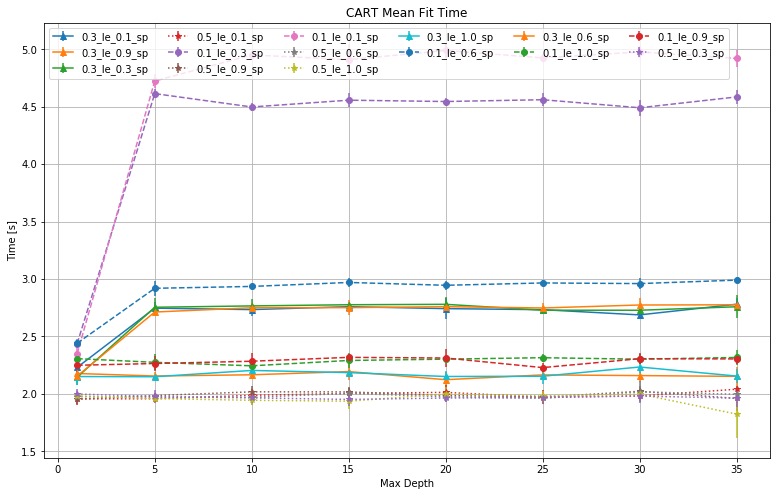

In [0]:
import ast
grid_result = pd.read_csv('CART_acc.csv')
def fill_params(parameters, leaf, sp, t, p, s):
    try:
        parameters['{}_le_{}_sp'.format(leaf, sp)]['time'].append(t)
        parameters['{}_le_{}_sp'.format(leaf, sp)]['d'].append(p['CART__max_depth'])
        parameters['{}_le_{}_sp'.format(leaf, sp)]['std'].append(s)
    except KeyError:
        parameters['{}_le_{}_sp'.format(leaf, sp)] = {'time': [], 'd': [], 'std': []}
        parameters['{}_le_{}_sp'.format(leaf, sp)]['time'].append(t)
        parameters['{}_le_{}_sp'.format(leaf, sp)]['d'].append(p['CART__max_depth'])
        parameters['{}_le_{}_sp'.format(leaf, sp)]['std'].append(s)

mean_fit_time = grid_result['mean_fit_time']
std_fit_time = grid_result['std_fit_time']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_fit_time, params, std_fit_time):
    p = ast.literal_eval(p)
    if p['CART__min_samples_leaf'] == 0.1:
        if p['CART__min_samples_split'] == 0.1:
            fill_params(parameters, 0.1, 0.1, t, p, s)
        elif p['CART__min_samples_split'] == 0.3:
            fill_params(parameters, 0.1, 0.3, t, p, s)
        elif p['CART__min_samples_split'] == 0.6:
            fill_params(parameters, 0.1, 0.6, t, p, s)
        elif p['CART__min_samples_split'] == 0.9:
            fill_params(parameters, 0.1, 0.9, t, p, s)
        else:
            fill_params(parameters, 0.1, 1.0, t, p, s)
    elif p['CART__min_samples_leaf'] == 0.3:
        if p['CART__min_samples_split'] == 0.1:
            fill_params(parameters, 0.3, 0.1, t, p, s)
        elif p['CART__min_samples_split'] == 0.3:
            fill_params(parameters, 0.3, 0.3, t, p, s)
        elif p['CART__min_samples_split'] == 0.6:
            fill_params(parameters, 0.3, 0.6, t, p, s)
        elif p['CART__min_samples_split'] == 0.9:
            fill_params(parameters, 0.3, 0.9, t, p, s)
        else:
            fill_params(parameters, 0.3, 1.0, t, p, s)
    else:
        if p['CART__min_samples_split'] == 0.1:
            fill_params(parameters, 0.5, 0.1, t, p, s)
        elif p['CART__min_samples_split'] == 0.3:
            fill_params(parameters, 0.5, 0.3, t, p, s)
        elif p['CART__min_samples_split'] == 0.6:
            fill_params(parameters, 0.5, 0.6, t, p, s)
        elif p['CART__min_samples_split'] == 0.9:
            fill_params(parameters, 0.5, 0.9, t, p, s)
        else:
            fill_params(parameters, 0.5, 1.0, t, p, s)
        
fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('CART Mean Fit Time')
for key, value in parameters.items():
    if '0.1_le' in key:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='o', linestyle='--')
    elif '0.3_le' in key:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='^', linestyle='-')
    else:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='*', linestyle=':')
ax.set_ylabel('Time [s]')
ax.set_xlabel('Max Depth')
ax.grid(True)
ax.legend(ncol=6, loc='upper left')

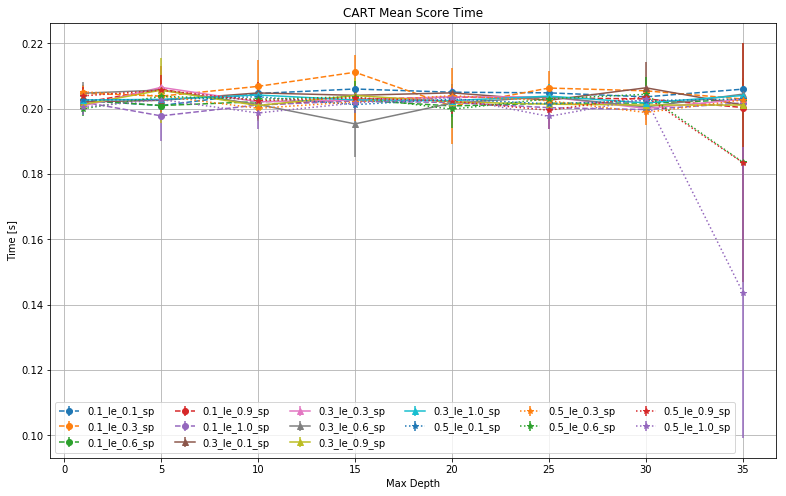

In [0]:
import ast
def fill_params(parameters, leaf, sp, t, p, s):
    try:
        parameters['{}_le_{}_sp'.format(leaf, sp)]['time'].append(t)
        parameters['{}_le_{}_sp'.format(leaf, sp)]['d'].append(p['CART__max_depth'])
        parameters['{}_le_{}_sp'.format(leaf, sp)]['std'].append(s)
    except KeyError:
        parameters['{}_le_{}_sp'.format(leaf, sp)] = {'time': [], 'd': [], 'std': []}
        parameters['{}_le_{}_sp'.format(leaf, sp)]['time'].append(t)
        parameters['{}_le_{}_sp'.format(leaf, sp)]['d'].append(p['CART__max_depth'])
        parameters['{}_le_{}_sp'.format(leaf, sp)]['std'].append(s)

mean_score_time = grid_result['mean_score_time']
std_score_time = grid_result['std_score_time']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_score_time, params, std_score_time):
    p = ast.literal_eval(p)
    if p['CART__min_samples_leaf'] == 0.1:
        if p['CART__min_samples_split'] == 0.1:
            fill_params(parameters, 0.1, 0.1, t, p, s)
        elif p['CART__min_samples_split'] == 0.3:
            fill_params(parameters, 0.1, 0.3, t, p, s)
        elif p['CART__min_samples_split'] == 0.6:
            fill_params(parameters, 0.1, 0.6, t, p, s)
        elif p['CART__min_samples_split'] == 0.9:
            fill_params(parameters, 0.1, 0.9, t, p, s)
        else:
            fill_params(parameters, 0.1, 1.0, t, p, s)
    elif p['CART__min_samples_leaf'] == 0.3:
        if p['CART__min_samples_split'] == 0.1:
            fill_params(parameters, 0.3, 0.1, t, p, s)
        elif p['CART__min_samples_split'] == 0.3:
            fill_params(parameters, 0.3, 0.3, t, p, s)
        elif p['CART__min_samples_split'] == 0.6:
            fill_params(parameters, 0.3, 0.6, t, p, s)
        elif p['CART__min_samples_split'] == 0.9:
            fill_params(parameters, 0.3, 0.9, t, p, s)
        else:
            fill_params(parameters, 0.3, 1.0, t, p, s)
    else:
        if p['CART__min_samples_split'] == 0.1:
            fill_params(parameters, 0.5, 0.1, t, p, s)
        elif p['CART__min_samples_split'] == 0.3:
            fill_params(parameters, 0.5, 0.3, t, p, s)
        elif p['CART__min_samples_split'] == 0.6:
            fill_params(parameters, 0.5, 0.6, t, p, s)
        elif p['CART__min_samples_split'] == 0.9:
            fill_params(parameters, 0.5, 0.9, t, p, s)
        else:
            fill_params(parameters, 0.5, 1.0, t, p, s)
        
fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('CART Mean Score Time')
for key, value in parameters.items():
    if '0.1_le' in key:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='o', linestyle='--')
    elif '0.3_le' in key:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='^', linestyle='-')
    else:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='*', linestyle=':')
ax.set_ylabel('Time [s]')
ax.set_xlabel('Max Depth')
ax.grid(True)
ax.legend(ncol=6)

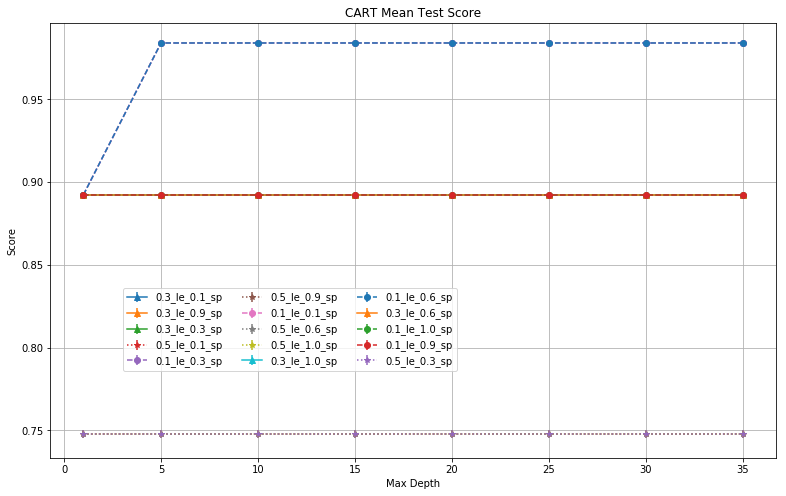

In [0]:
import ast
def fill_params(parameters, leaf, sp, t, p, s):
    try:
        parameters['{}_le_{}_sp'.format(leaf, sp)]['test_score'].append(t)
        parameters['{}_le_{}_sp'.format(leaf, sp)]['d'].append(p['CART__max_depth'])
        parameters['{}_le_{}_sp'.format(leaf, sp)]['std'].append(s)
    except KeyError:
        parameters['{}_le_{}_sp'.format(leaf, sp)] = {'test_score': [], 'd': [], 'std': []}
        parameters['{}_le_{}_sp'.format(leaf, sp)]['test_score'].append(t)
        parameters['{}_le_{}_sp'.format(leaf, sp)]['d'].append(p['CART__max_depth'])
        parameters['{}_le_{}_sp'.format(leaf, sp)]['std'].append(s)

mean_test_score = grid_result['mean_test_score']
std_test_score = grid_result['std_test_score']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_test_score, params, std_test_score):
    p = ast.literal_eval(p)
    if p['CART__min_samples_leaf'] == 0.1:
        if p['CART__min_samples_split'] == 0.1:
            fill_params(parameters, 0.1, 0.1, t, p, s)
        elif p['CART__min_samples_split'] == 0.3:
            fill_params(parameters, 0.1, 0.3, t, p, s)
        elif p['CART__min_samples_split'] == 0.6:
            fill_params(parameters, 0.1, 0.6, t, p, s)
        elif p['CART__min_samples_split'] == 0.9:
            fill_params(parameters, 0.1, 0.9, t, p, s)
        else:
            fill_params(parameters, 0.1, 1.0, t, p, s)
    elif p['CART__min_samples_leaf'] == 0.3:
        if p['CART__min_samples_split'] == 0.1:
            fill_params(parameters, 0.3, 0.1, t, p, s)
        elif p['CART__min_samples_split'] == 0.3:
            fill_params(parameters, 0.3, 0.3, t, p, s)
        elif p['CART__min_samples_split'] == 0.6:
            fill_params(parameters, 0.3, 0.6, t, p, s)
        elif p['CART__min_samples_split'] == 0.9:
            fill_params(parameters, 0.3, 0.9, t, p, s)
        else:
            fill_params(parameters, 0.3, 1.0, t, p, s)
    else:
        if p['CART__min_samples_split'] == 0.1:
            fill_params(parameters, 0.5, 0.1, t, p, s)
        elif p['CART__min_samples_split'] == 0.3:
            fill_params(parameters, 0.5, 0.3, t, p, s)
        elif p['CART__min_samples_split'] == 0.6:
            fill_params(parameters, 0.5, 0.6, t, p, s)
        elif p['CART__min_samples_split'] == 0.9:
            fill_params(parameters, 0.5, 0.9, t, p, s)
        else:
            fill_params(parameters, 0.5, 1.0, t, p, s)
        
fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('CART Mean Test Score')
for key, value in parameters.items():
    if '0.1_le' in key:
        ax.errorbar(value['d'], value['test_score'], value['std'], label=key, marker='o', linestyle='--')
    elif '0.3_le' in key:
        ax.errorbar(value['d'], value['test_score'], value['std'], label=key, marker='^', linestyle='-')
    else:
        ax.errorbar(value['d'], value['test_score'], value['std'], label=key, marker='*', linestyle=':')
ax.set_ylabel('Score')
ax.set_xlabel('Max Depth')
ax.grid(True)
ax.legend(ncol=3, loc=[0.1,0.2])

# CART neg log loss

In [0]:
max_depth = [1, 5, 10, 15, 20, 25, 30, 35]
min_samples_split = [0.1, 0.3, 0.6, 0.9, 1.0]
min_samples_leaf = [0.1, 0.3, 0.5]
# http://scikit-learn.org/stable/modules/tree.html
# https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3
                                                         
num_fold = 5
seed = 7
scoring = 'neg_log_loss'
param_grid = {'CART__max_depth': max_depth, 'CART__min_samples_split': min_samples_split, 'CART__min_samples_leaf': min_samples_leaf}
print(pipelines[3][0])
model = pipelines[3][1] # Linear Regression model
kfold = KFold(n_splits=num_fold, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)
grid_result = grid.fit(training, y_training)
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format(mean, stdev, param))
pd.DataFrame(grid_result.cv_results_).to_csv('CART_nll.csv')
grid_result = pd.read_csv('CART_nll.csv')

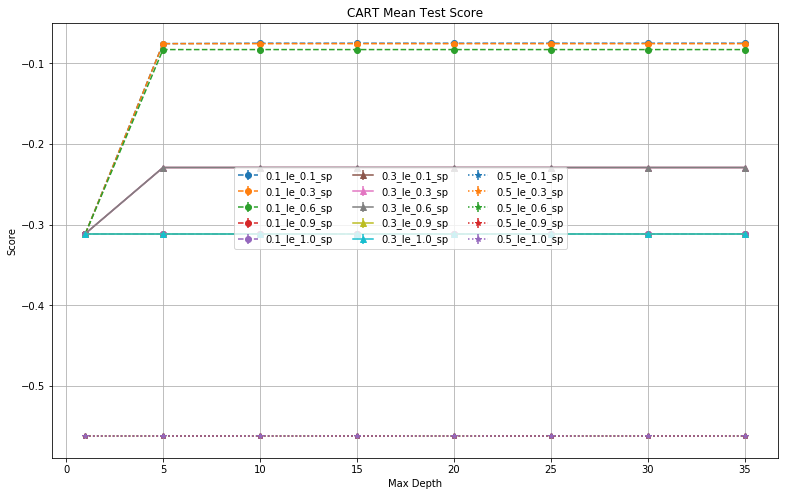

In [0]:
import ast
def fill_params(parameters, leaf, sp, t, p, s):
    try:
        parameters['{}_le_{}_sp'.format(leaf, sp)]['test_score'].append(t)
        parameters['{}_le_{}_sp'.format(leaf, sp)]['d'].append(p['CART__max_depth'])
        parameters['{}_le_{}_sp'.format(leaf, sp)]['std'].append(s)
    except KeyError:
        parameters['{}_le_{}_sp'.format(leaf, sp)] = {'test_score': [], 'd': [], 'std': []}
        parameters['{}_le_{}_sp'.format(leaf, sp)]['test_score'].append(t)
        parameters['{}_le_{}_sp'.format(leaf, sp)]['d'].append(p['CART__max_depth'])
        parameters['{}_le_{}_sp'.format(leaf, sp)]['std'].append(s)

mean_test_score = grid_result['mean_test_score']
std_test_score = grid_result['std_test_score']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_test_score, params, std_test_score):
    p = ast.literal_eval(p)
    if p['CART__min_samples_leaf'] == 0.1:
        if p['CART__min_samples_split'] == 0.1:
            fill_params(parameters, 0.1, 0.1, t, p, s)
        elif p['CART__min_samples_split'] == 0.3:
            fill_params(parameters, 0.1, 0.3, t, p, s)
        elif p['CART__min_samples_split'] == 0.6:
            fill_params(parameters, 0.1, 0.6, t, p, s)
        elif p['CART__min_samples_split'] == 0.9:
            fill_params(parameters, 0.1, 0.9, t, p, s)
        else:
            fill_params(parameters, 0.1, 1.0, t, p, s)
    elif p['CART__min_samples_leaf'] == 0.3:
        if p['CART__min_samples_split'] == 0.1:
            fill_params(parameters, 0.3, 0.1, t, p, s)
        elif p['CART__min_samples_split'] == 0.3:
            fill_params(parameters, 0.3, 0.3, t, p, s)
        elif p['CART__min_samples_split'] == 0.6:
            fill_params(parameters, 0.3, 0.6, t, p, s)
        elif p['CART__min_samples_split'] == 0.9:
            fill_params(parameters, 0.3, 0.9, t, p, s)
        else:
            fill_params(parameters, 0.3, 1.0, t, p, s)
    else:
        if p['CART__min_samples_split'] == 0.1:
            fill_params(parameters, 0.5, 0.1, t, p, s)
        elif p['CART__min_samples_split'] == 0.3:
            fill_params(parameters, 0.5, 0.3, t, p, s)
        elif p['CART__min_samples_split'] == 0.6:
            fill_params(parameters, 0.5, 0.6, t, p, s)
        elif p['CART__min_samples_split'] == 0.9:
            fill_params(parameters, 0.5, 0.9, t, p, s)
        else:
            fill_params(parameters, 0.5, 1.0, t, p, s)
        
fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('CART Mean Test Score')
for key, value in parameters.items():
    if '0.1_le' in key:
        ax.errorbar(value['d'], value['test_score'], value['std'], label=key, marker='o', linestyle='--')
    elif '0.3_le' in key:
        ax.errorbar(value['d'], value['test_score'], value['std'], label=key, marker='^', linestyle='-')
    else:
        ax.errorbar(value['d'], value['test_score'], value['std'], label=key, marker='*', linestyle=':')
ax.set_ylabel('Score')
ax.set_xlabel('Max Depth')
ax.grid(True)
ax.legend(ncol=3, loc=[0.25,0.48])

# AB neg log loss

In [0]:
n_estimators = [1, 5, 10, 20, 30, 40, 50, 80, 100]
learning_rate = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
algorithm = ['SAMME', 'SAMME.R']
# http://scikit-learn.org/stable/modules/ensemble.html#adaboost
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
                                                         
num_fold = 5
seed = 7
scoring = 'neg_log_loss'
param_grid = {'n_estimators': n_estimators, "learning_rate": learning_rate, "algorithm": algorithm}
print(pipelines[6][0])
model = pipelines[6][1] # AdaBoost model
kfold = KFold(n_splits=num_fold, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(training.head(10000), y_training[0:10000])
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format(mean, stdev, param))
pd.DataFrame(grid_result.cv_results_).to_csv('AD_nll.csv')
grid_result = pd.read_csv('AD_nll.csv')

In [0]:
import ast
def fill_params(parameters, alg, lr, t, p, s):
    try:
        parameters['{}_{}_lr'.format(alg, lr)]['time'].append(t)
        parameters['{}_{}_lr'.format(alg, lr)]['n'].append(p['n_estimators'])
        parameters['{}_{}_lr'.format(alg, lr)]['std'].append(s)
    except KeyError:
        parameters['{}_{}_lr'.format(alg, lr)] = {'time': [], 'n': [], 'std': []}
        parameters['{}_{}_lr'.format(alg, lr)]['time'].append(t)
        parameters['{}_{}_lr'.format(alg, lr)]['n'].append(p['n_estimators'])
        parameters['{}_{}_lr'.format(alg, lr)]['std'].append(s)

mean_fit_time = grid_result['mean_fit_time']
std_fit_time = grid_result['std_fit_time']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_fit_time, params, std_fit_time):
    p = ast.literal_eval(p)
    if p['algorithm'] == 'SAMME':
        if p['learning_rate'] == 0.001:
            fill_params(parameters, 'SAMME', 0.001, t, p, s)
        elif p['learning_rate'] == 0.01:
            fill_params(parameters, 'SAMME', 0.01, t, p, s)
        elif p['learning_rate'] == 0.1:
            fill_params(parameters, 'SAMME', 0.1, t, p, s)
        elif p['learning_rate'] == 1.0:
            fill_params(parameters, 'SAMME', 1.0, t, p, s)
        elif p['learning_rate'] == 10.0:
            fill_params(parameters, 'SAMME', 10.0, t, p, s)
        else:
            fill_params(parameters, 'SAMME', 100.0, t, p, s)
    else:
        if p['learning_rate'] == 0.001:
            fill_params(parameters, 'SAMME.R', 0.001, t, p, s)
        elif p['learning_rate'] == 0.01:
            fill_params(parameters, 'SAMME.R', 0.01, t, p, s)
        elif p['learning_rate'] == 0.1:
            fill_params(parameters, 'SAMME.R', 0.1, t, p, s)
        elif p['learning_rate'] == 1.0:
            fill_params(parameters, 'SAMME.R', 1.0, t, p, s)
        elif p['learning_rate'] == 10.0:
            fill_params(parameters, 'SAMME.R', 10.0, t, p, s)
        else:
            fill_params(parameters, 'SAMME.R', 100.0, t, p, s)

fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('AdaBoost Mean Fit Time')
for key, value in parameters.items():
    if 'SAMME.R' in key:
        ax.errorbar(value['n'], value['time'], value['std'], label=key, marker='o', linestyle='--')
    else:
        ax.errorbar(value['n'], value['time'], value['std'], label=key, marker='^', linestyle='-')
ax.set_ylabel('Time [s]')
ax.set_xlabel('n_estimators')
ax.grid(True)
ax.legend()

In [0]:
import ast
def fill_params(parameters, alg, lr, t, p, s):
    try:
        parameters['{}_{}_lr'.format(alg, lr)]['time'].append(t)
        parameters['{}_{}_lr'.format(alg, lr)]['n'].append(p['n_estimators'])
        parameters['{}_{}_lr'.format(alg, lr)]['std'].append(s)
    except KeyError:
        parameters['{}_{}_lr'.format(alg, lr)] = {'time': [], 'n': [], 'std': []}
        parameters['{}_{}_lr'.format(alg, lr)]['time'].append(t)
        parameters['{}_{}_lr'.format(alg, lr)]['n'].append(p['n_estimators'])
        parameters['{}_{}_lr'.format(alg, lr)]['std'].append(s)

mean_score_time = grid_result['mean_score_time']
std_score_time = grid_result['std_score_time']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_score_time, params, std_score_time):
    p = ast.literal_eval(p)
    if p['algorithm'] == 'SAMME':
        if p['learning_rate'] == 0.001:
            fill_params(parameters, 'SAMME', 0.001, t, p, s)
        elif p['learning_rate'] == 0.01:
            fill_params(parameters, 'SAMME', 0.01, t, p, s)
        elif p['learning_rate'] == 0.1:
            fill_params(parameters, 'SAMME', 0.1, t, p, s)
        elif p['learning_rate'] == 1.0:
            fill_params(parameters, 'SAMME', 1.0, t, p, s)
        elif p['learning_rate'] == 10.0:
            fill_params(parameters, 'SAMME', 10.0, t, p, s)
        else:
            fill_params(parameters, 'SAMME', 100.0, t, p, s)
    else:
        if p['learning_rate'] == 0.001:
            fill_params(parameters, 'SAMME.R', 0.001, t, p, s)
        elif p['learning_rate'] == 0.01:
            fill_params(parameters, 'SAMME.R', 0.01, t, p, s)
        elif p['learning_rate'] == 0.1:
            fill_params(parameters, 'SAMME.R', 0.1, t, p, s)
        elif p['learning_rate'] == 1.0:
            fill_params(parameters, 'SAMME.R', 1.0, t, p, s)
        elif p['learning_rate'] == 10.0:
            fill_params(parameters, 'SAMME.R', 10.0, t, p, s)
        else:
            fill_params(parameters, 'SAMME.R', 100.0, t, p, s)

fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('AdaBoost Mean Score Time')
for key, value in parameters.items():
    if 'SAMME.R' in key:
        ax.errorbar(value['n'], value['time'], value['std'], label=key, marker='o', linestyle='--')
    else:
        ax.errorbar(value['n'], value['time'], value['std'], label=key, marker='^', linestyle='-')
ax.set_ylabel('Time [s]')
ax.set_xlabel('n_estimators')
ax.grid(True)
ax.legend()

In [0]:
def fill_params(parameters, alg, n, t, p, s):
    try:
        parameters['{}_{}_n'.format(alg, n)]['test_score'].append(t)
        parameters['{}_{}_n'.format(alg, n)]['lr'].append(p['learning_rate'])
        parameters['{}_{}_n'.format(alg, n)]['std'].append(s)
    except KeyError:
        parameters['{}_{}_n'.format(alg, n)] = {'test_score': [], 'lr': [], 'std': []}
        parameters['{}_{}_n'.format(alg, n)]['test_score'].append(t)
        parameters['{}_{}_n'.format(alg, n)]['lr'].append(p['learning_rate'])
        parameters['{}_{}_n'.format(alg, n)]['std'].append(s)

mean_test_score = grid_result['mean_test_score']
std_test_score = grid_result['std_test_score']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_test_score, params, std_test_score):
    p = ast.literal_eval(p)
    if p['algorithm'] == 'SAMME':
        if p['n_estimators'] == 1:
            fill_params(parameters, 'SAMME', 1, t, p, s)
        elif p['n_estimators'] == 5:
            fill_params(parameters, 'SAMME', 5, t, p, s)
        elif p['n_estimators'] == 10:
            fill_params(parameters, 'SAMME', 10, t, p, s)
        elif p['n_estimators'] == 20:
            fill_params(parameters, 'SAMME', 20, t, p, s)
        elif p['n_estimators'] == 30:
            fill_params(parameters, 'SAMME', 30, t, p, s)
        elif p['n_estimators'] == 40:
            fill_params(parameters, 'SAMME', 40, t, p, s)
        elif p['n_estimators'] == 50:
            fill_params(parameters, 'SAMME', 50, t, p, s)
        elif p['n_estimators'] == 80:
            fill_params(parameters, 'SAMME', 80, t, p, s)
        else:
            fill_params(parameters, 'SAMME', 100, t, p, s)
    else:
        if p['n_estimators'] == 1:
            fill_params(parameters, 'SAMME.R', 1, t, p, s)
        elif p['n_estimators'] == 5:
            fill_params(parameters, 'SAMME.R', 5, t, p, s)
        elif p['n_estimators'] == 10:
            fill_params(parameters, 'SAMME.R', 10, t, p, s)
        elif p['n_estimators'] == 20:
            fill_params(parameters, 'SAMME.R', 20, t, p, s)
        elif p['n_estimators'] == 30:
            fill_params(parameters, 'SAMME.R', 30, t, p, s)
        elif p['n_estimators'] == 40:
            fill_params(parameters, 'SAMME.R', 40, t, p, s)
        elif p['n_estimators'] == 50:
            fill_params(parameters, 'SAMME.R', 50, t, p, s)
        elif p['n_estimators'] == 80:
            fill_params(parameters, 'SAMME.R', 80, t, p, s)
        else:
            fill_params(parameters, 'SAMME.R', 100, t, p, s)

fig, ax = plt.subplots(1,1, figsize=(18,8))
ax.set_title('AdaBoost Mean Test Score')
for key, value in parameters.items():
    if 'SAMME.R' in key:
        ax.errorbar(value['lr'], value['test_score'], value['std'], label=key, marker='o', linestyle='--')
    else:
        ax.errorbar(value['lr'], value['test_score'], value['std'], label=key, marker='^', linestyle='-')
ax.set_ylabel('Score')
ax.set_xlabel('Learning rate')
ax.grid(True)
ax.legend(ncol=3)

# AD acc

In [0]:
n_estimators = [1, 5, 10, 20, 30, 40, 50, 80, 100]
learning_rate = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
algorithm = ['SAMME', 'SAMME.R']
# http://scikit-learn.org/stable/modules/ensemble.html#adaboost
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
                                                         
num_fold = 5
seed = 7
scoring = 'accuracy'
param_grid = {'n_estimators': n_estimators, "learning_rate": learning_rate, "algorithm": algorithm}
print(pipelines[6][0])
model = pipelines[6][1] # AdaBoost model
kfold = KFold(n_splits=num_fold, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(training.head(10000), y_training[0:10000])
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format(mean, stdev, param))
pd.DataFrame(grid_result.cv_results_).to_csv('AD_acc.csv')
grid_result = pd.read_csv('AD_acc.csv')

In [0]:
def fill_params(parameters, alg, n, t, p, s):
    try:
        parameters['{}_{}_n'.format(alg, n)]['test_score'].append(t)
        parameters['{}_{}_n'.format(alg, n)]['lr'].append(p['learning_rate'])
        parameters['{}_{}_n'.format(alg, n)]['std'].append(s)
    except KeyError:
        parameters['{}_{}_n'.format(alg, n)] = {'test_score': [], 'lr': [], 'std': []}
        parameters['{}_{}_n'.format(alg, n)]['test_score'].append(t)
        parameters['{}_{}_n'.format(alg, n)]['lr'].append(p['learning_rate'])
        parameters['{}_{}_n'.format(alg, n)]['std'].append(s)

mean_test_score = grid_result['mean_test_score']
std_test_score = grid_result['std_test_score']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_test_score, params, std_test_score):
    p = ast.literal_eval(p)
    if p['algorithm'] == 'SAMME':
        if p['n_estimators'] == 1:
            fill_params(parameters, 'SAMME', 1, t, p, s)
        elif p['n_estimators'] == 5:
            fill_params(parameters, 'SAMME', 5, t, p, s)
        elif p['n_estimators'] == 10:
            fill_params(parameters, 'SAMME', 10, t, p, s)
        elif p['n_estimators'] == 20:
            fill_params(parameters, 'SAMME', 20, t, p, s)
        elif p['n_estimators'] == 30:
            fill_params(parameters, 'SAMME', 30, t, p, s)
        elif p['n_estimators'] == 40:
            fill_params(parameters, 'SAMME', 40, t, p, s)
        elif p['n_estimators'] == 50:
            fill_params(parameters, 'SAMME', 50, t, p, s)
        elif p['n_estimators'] == 80:
            fill_params(parameters, 'SAMME', 80, t, p, s)
        else:
            fill_params(parameters, 'SAMME', 100, t, p, s)
    else:
        if p['n_estimators'] == 1:
            fill_params(parameters, 'SAMME.R', 1, t, p, s)
        elif p['n_estimators'] == 5:
            fill_params(parameters, 'SAMME.R', 5, t, p, s)
        elif p['n_estimators'] == 10:
            fill_params(parameters, 'SAMME.R', 10, t, p, s)
        elif p['n_estimators'] == 20:
            fill_params(parameters, 'SAMME.R', 20, t, p, s)
        elif p['n_estimators'] == 30:
            fill_params(parameters, 'SAMME.R', 30, t, p, s)
        elif p['n_estimators'] == 40:
            fill_params(parameters, 'SAMME.R', 40, t, p, s)
        elif p['n_estimators'] == 50:
            fill_params(parameters, 'SAMME.R', 50, t, p, s)
        elif p['n_estimators'] == 80:
            fill_params(parameters, 'SAMME.R', 80, t, p, s)
        else:
            fill_params(parameters, 'SAMME.R', 100, t, p, s)

fig, ax = plt.subplots(1,1, figsize=(18,8))
ax.set_title('AdaBoost Mean Test Score')
for key, value in parameters.items():
    if 'SAMME.R' in key:
        ax.errorbar(value['lr'], value['test_score'], value['std'], label=key, marker='o', linestyle='--')
    else:
        ax.errorbar(value['lr'], value['test_score'], value['std'], label=key, marker='^', linestyle='-')
ax.set_ylabel('Score')
ax.set_xlabel('Learning rate')
ax.grid(True)
ax.legend(ncol=3)

# RF acc

In [0]:
max_depth = [10, 40, 70, 100]
n_estimators = [200, 800, 1400, 2000]
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
                                                    
num_fold = 5
seed = 7
scoring = 'accuracy'
param_grid = {'max_depth': max_depth, 'n_estimators': n_estimators}
print(pipelines[8][0])
model = pipelines[8][1] # RF model
kfold = KFold(n_splits=num_fold, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)
grid_result = grid.fit(training, y_training)
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format(mean, stdev, param))
pd.DataFrame(grid_result.cv_results_).to_csv('RF_acc.csv')
grid_result = pd.read_csv('RF_acc.csv')

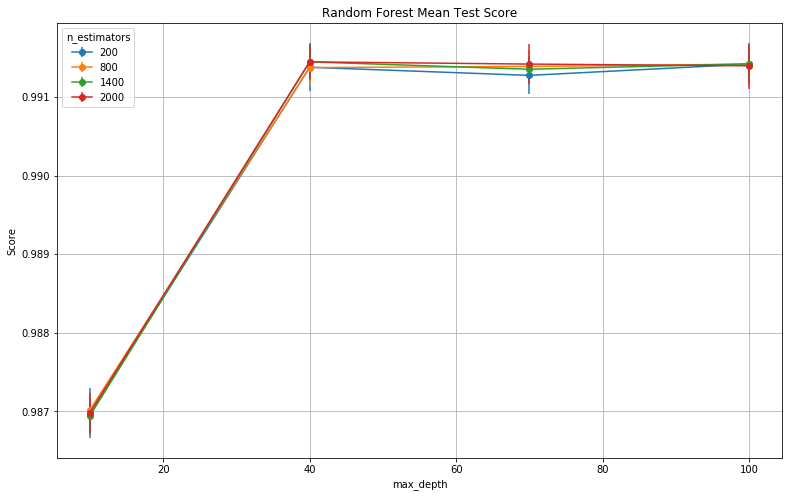

In [0]:
import ast
def fill_params(parameters, n, t, p, s):
    try:
        parameters['{}'.format(n)]['score'].append(t)
        parameters['{}'.format(n)]['max_depth'].append(p['max_depth'])
        parameters['{}'.format(n)]['std'].append(s)
    except KeyError:
        parameters['{}'.format(n)] = {'score': [], 'max_depth': [], 'std': []}
        parameters['{}'.format(n)]['score'].append(t)
        parameters['{}'.format(n)]['max_depth'].append(p['max_depth'])
        parameters['{}'.format(n)]['std'].append(s)

mean_test_score = grid_result['mean_test_score']
std_test_score = grid_result['std_test_score']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_test_score, params, std_test_score):
    p = ast.literal_eval(p)
    fill_params(parameters, p['n_estimators'], t, p, s)

fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('Random Forest Mean Test Score')
for key, value in parameters.items():
    ax.errorbar(value['max_depth'], value['score'], value['std'], label=key, marker='o', linestyle='-')
ax.set_ylabel('Score')
ax.set_xlabel('max_depth')
ax.grid(True)
ax.legend(title='n_estimators')

In [0]:
grid_result = pd.read_csv('RF_acc.csv')

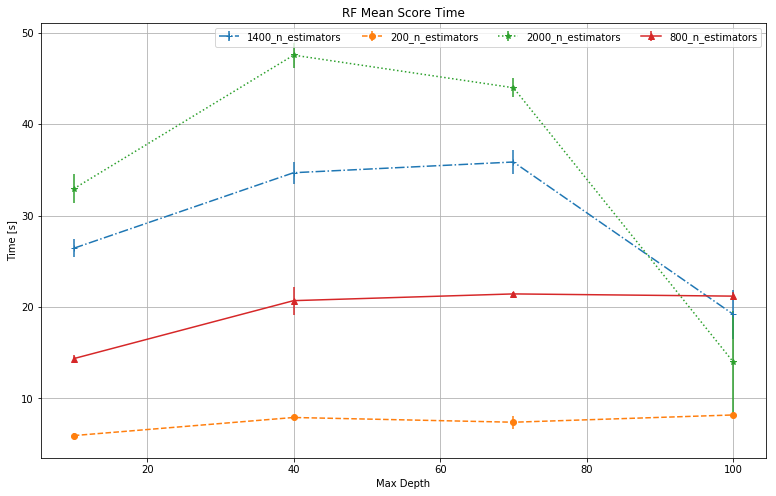

In [0]:
import ast
def fill_params(parameters, depth, est, t, p, s):
    try:
        parameters['{}_n_estimators'.format(est)]['time'].append(t)
        parameters['{}_n_estimators'.format(est)]['d'].append(p['max_depth'])
        parameters['{}_n_estimators'.format(est)]['std'].append(s)
    except KeyError:
        parameters['{}_n_estimators'.format(est)] = {'time': [], 'd': [], 'std': []}
        parameters['{}_n_estimators'.format(est)]['time'].append(t)
        parameters['{}_n_estimators'.format(est)]['d'].append(p['max_depth'])
        parameters['{}_n_estimators'.format(est)]['std'].append(s)

mean_score_time = grid_result['mean_score_time']
std_score_time = grid_result['std_score_time']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_score_time, params, std_score_time):
    p = ast.literal_eval(p)
    if p['max_depth'] == 10:
        if p['n_estimators'] == 200:
            fill_params(parameters, 10, 200, t, p, s)
        elif p['n_estimators'] == 800:
            fill_params(parameters, 10, 800, t, p, s)
        elif p['n_estimators'] == 1400:
            fill_params(parameters, 10, 1400, t, p, s)
        elif p['n_estimators'] == 2000:
            fill_params(parameters, 10, 2000, t, p, s)
    elif p['max_depth'] == 40:
        if p['n_estimators'] == 200:
            fill_params(parameters, 40, 200, t, p, s)
        elif p['n_estimators'] == 800:
            fill_params(parameters, 40, 800, t, p, s)
        elif p['n_estimators'] == 1400:
            fill_params(parameters, 40, 1400, t, p, s)
        elif p['n_estimators'] == 2000:
            fill_params(parameters, 40, 2000, t, p, s)
    elif p['max_depth'] == 70:
        if p['n_estimators'] == 200:
            fill_params(parameters, 70, 200, t, p, s)
        elif p['n_estimators'] == 800:
            fill_params(parameters, 70, 800, t, p, s)
        elif p['n_estimators'] == 1400:
            fill_params(parameters, 70, 1400, t, p, s)
        elif p['n_estimators'] == 2000:
            fill_params(parameters, 70, 2000, t, p, s)
    else:
        if p['n_estimators'] == 200:
            fill_params(parameters, 200, 200, t, p, s)
        elif p['n_estimators'] == 800:
            fill_params(parameters, 200, 800, t, p, s)
        elif p['n_estimators'] == 1400:
            fill_params(parameters, 200, 1400, t, p, s)
        elif p['n_estimators'] == 2000:
            fill_params(parameters, 200, 2000, t, p, s)
        
fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('RF Mean Score Time')
for key, value in parameters.items():
    if '200_' in key:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='o', linestyle='--')
    elif '800_' in key:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='^', linestyle='-')
    elif '1400_' in key:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='+', linestyle='-.')
    else:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='*', linestyle=':')
ax.set_ylabel('Time [s]')
ax.set_xlabel('Max Depth')
ax.grid(True)
ax.legend(ncol=6)

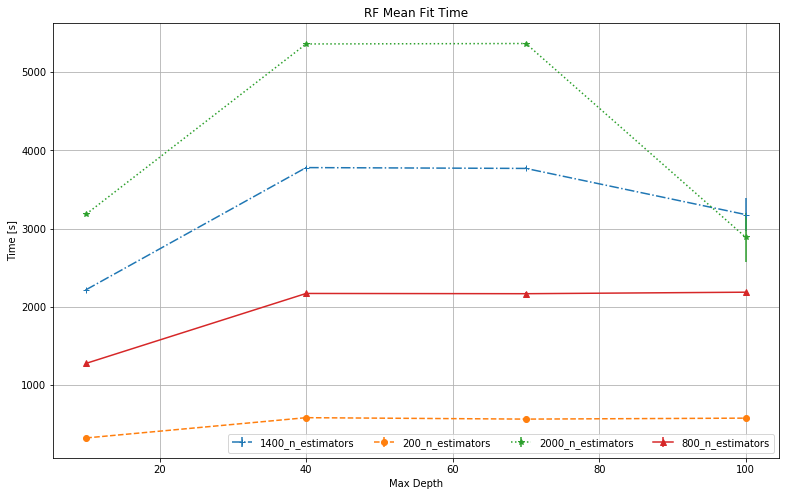

In [0]:
import ast
def fill_params(parameters, depth, est, t, p, s):
    try:
        parameters['{}_n_estimators'.format(est)]['time'].append(t)
        parameters['{}_n_estimators'.format(est)]['d'].append(p['max_depth'])
        parameters['{}_n_estimators'.format(est)]['std'].append(s)
    except KeyError:
        parameters['{}_n_estimators'.format(est)] = {'time': [], 'd': [], 'std': []}
        parameters['{}_n_estimators'.format(est)]['time'].append(t)
        parameters['{}_n_estimators'.format(est)]['d'].append(p['max_depth'])
        parameters['{}_n_estimators'.format(est)]['std'].append(s)

mean_score_time = grid_result['mean_fit_time']
std_score_time = grid_result['std_fit_time']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_score_time, params, std_score_time):
    p = ast.literal_eval(p)
    if p['max_depth'] == 10:
        if p['n_estimators'] == 200:
            fill_params(parameters, 10, 200, t, p, s)
        elif p['n_estimators'] == 800:
            fill_params(parameters, 10, 800, t, p, s)
        elif p['n_estimators'] == 1400:
            fill_params(parameters, 10, 1400, t, p, s)
        elif p['n_estimators'] == 2000:
            fill_params(parameters, 10, 2000, t, p, s)
    elif p['max_depth'] == 40:
        if p['n_estimators'] == 200:
            fill_params(parameters, 40, 200, t, p, s)
        elif p['n_estimators'] == 800:
            fill_params(parameters, 40, 800, t, p, s)
        elif p['n_estimators'] == 1400:
            fill_params(parameters, 40, 1400, t, p, s)
        elif p['n_estimators'] == 2000:
            fill_params(parameters, 40, 2000, t, p, s)
    elif p['max_depth'] == 70:
        if p['n_estimators'] == 200:
            fill_params(parameters, 70, 200, t, p, s)
        elif p['n_estimators'] == 800:
            fill_params(parameters, 70, 800, t, p, s)
        elif p['n_estimators'] == 1400:
            fill_params(parameters, 70, 1400, t, p, s)
        elif p['n_estimators'] == 2000:
            fill_params(parameters, 70, 2000, t, p, s)
    else:
        if p['n_estimators'] == 200:
            fill_params(parameters, 200, 200, t, p, s)
        elif p['n_estimators'] == 800:
            fill_params(parameters, 200, 800, t, p, s)
        elif p['n_estimators'] == 1400:
            fill_params(parameters, 200, 1400, t, p, s)
        elif p['n_estimators'] == 2000:
            fill_params(parameters, 200, 2000, t, p, s)
        
fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('RF Mean Fit Time')
for key, value in parameters.items():
    if '200_' in key:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='o', linestyle='--')
    elif '800_' in key:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='^', linestyle='-')
    elif '1400_' in key:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='+', linestyle='-.')
    else:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='*', linestyle=':')
ax.set_ylabel('Time [s]')
ax.set_xlabel('Max Depth')
ax.grid(True)
ax.legend(ncol=6)

# RF neg log loss

In [0]:
max_depth = [10, 40, 70, 100]
n_estimators = [200, 800, 1400, 2000]
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
                                                    
num_fold = 5
seed = 7
scoring = 'neg_log_loss'
param_grid = {'max_depth': max_depth, 'n_estimators': n_estimators}
print(pipelines[8][0])
model = pipelines[8][1] # RF model
kfold = KFold(n_splits=num_fold, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)
grid_result = grid.fit(training, y_training)
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format(mean, stdev, param))
pd.DataFrame(grid_result.cv_results_).to_csv('RF_nll.csv')
grid_result = pd.read_csv('RF_nll.csv')

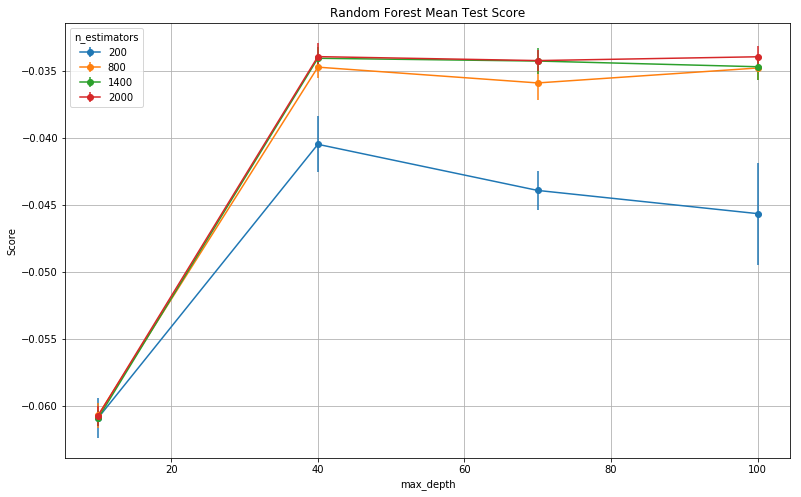

In [0]:
import ast
def fill_params(parameters, n, t, p, s):
    try:
        parameters['{}'.format(n)]['score'].append(t)
        parameters['{}'.format(n)]['max_depth'].append(p['max_depth'])
        parameters['{}'.format(n)]['std'].append(s)
    except KeyError:
        parameters['{}'.format(n)] = {'score': [], 'max_depth': [], 'std': []}
        parameters['{}'.format(n)]['score'].append(t)
        parameters['{}'.format(n)]['max_depth'].append(p['max_depth'])
        parameters['{}'.format(n)]['std'].append(s)

mean_test_score = grid_result['mean_test_score']
std_test_score = grid_result['std_test_score']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_test_score, params, std_test_score):
    p = ast.literal_eval(p)
    fill_params(parameters, p['n_estimators'], t, p, s)

fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('Random Forest Mean Test Score')
for key, value in parameters.items():
    ax.errorbar(value['max_depth'], value['score'], value['std'], label=key, marker='o', linestyle='-')
ax.set_ylabel('Score')
ax.set_xlabel('max_depth')
ax.grid(True)
ax.legend(title='n_estimators')

# GB acc

In [0]:
learning_rate = [0.01, 0.1, 1.0, 10.0, 100.0]
n_estimators = [10, 100, 150]
max_depth = [1, 5]

                                                         
num_fold = 5
seed = 7
scoring = 'accuracy'
param_grid = {'learning_rate': learning_rate, 'n_estimators': n_estimators, 'max_depth': max_depth}
print(pipelines[7][0])
model = pipelines[7][1] # Gradient Boosting model
kfold = KFold(n_splits=num_fold, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)
grid_result = grid.fit(training, y_training)
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format(mean, stdev, param))
pd.DataFrame(grid_result.cv_results_).to_csv('GB_acc.csv')
grid_result = pd.read_csv('GB_acc.csv')

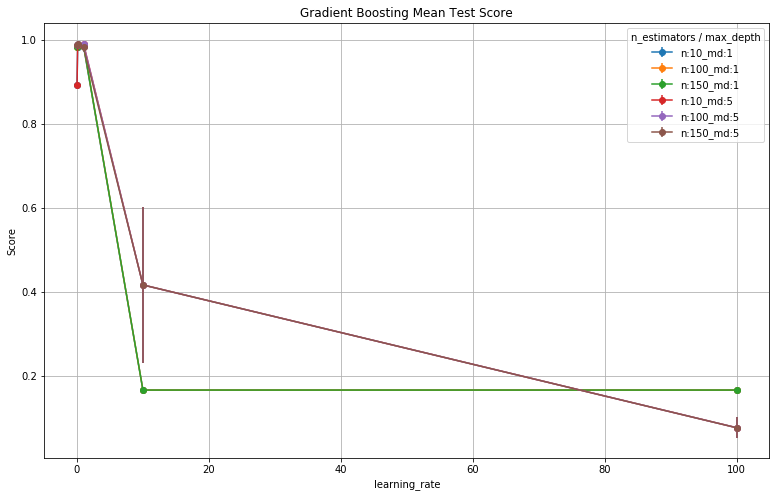

In [0]:
import ast
def fill_params(parameters, n, md, t, p, s):
    try:
        parameters['n:{}_md:{}'.format(n, md)]['score'].append(t)
        parameters['n:{}_md:{}'.format(n, md)]['learning_rate'].append(p['learning_rate'])
        parameters['n:{}_md:{}'.format(n, md)]['std'].append(s)
    except KeyError:
        parameters['n:{}_md:{}'.format(n, md)] = {'score': [], 'learning_rate': [], 'std': []}
        parameters['n:{}_md:{}'.format(n, md)]['score'].append(t)
        parameters['n:{}_md:{}'.format(n, md)]['learning_rate'].append(p['learning_rate'])
        parameters['n:{}_md:{}'.format(n, md)]['std'].append(s)

mean_test_score = grid_result['mean_test_score']
std_test_score = grid_result['std_test_score']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_test_score, params, std_test_score):
    p = ast.literal_eval(p)
    fill_params(parameters, p['n_estimators'], p['max_depth'], t, p, s)

fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('Gradient Boosting Mean Test Score')
for key, value in parameters.items():
    ax.errorbar(value['learning_rate'], value['score'], value['std'], label=key, marker='o', linestyle='-')
ax.set_ylabel('Score')
ax.set_xlabel('learning_rate')
ax.grid(True)
ax.legend(title='n_estimators / max_depth')

In [0]:
grid_result = pd.read_csv('GB_acc.csv')

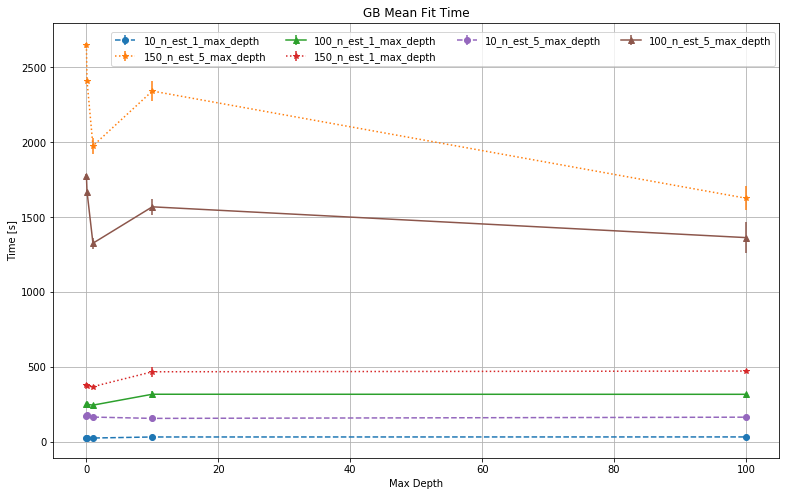

In [0]:
import ast
def fill_params(parameters, n_est, md, t, p, s):
    try:
        parameters['{}_n_est_{}_max_depth'.format(n_est, md)]['time'].append(t)
        parameters['{}_n_est_{}_max_depth'.format(n_est, md)]['d'].append(p['learning_rate'])
        parameters['{}_n_est_{}_max_depth'.format(n_est, md)]['std'].append(s)
    except KeyError:
        parameters['{}_n_est_{}_max_depth'.format(n_est, md)] = {'time': [], 'd': [], 'std': []}
        parameters['{}_n_est_{}_max_depth'.format(n_est, md)]['time'].append(t)
        parameters['{}_n_est_{}_max_depth'.format(n_est, md)]['d'].append(p['learning_rate'])
        parameters['{}_n_est_{}_max_depth'.format(n_est, md)]['std'].append(s)

mean_fit_time = grid_result['mean_fit_time']
std_fit_time = grid_result['std_fit_time']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_fit_time, params, std_fit_time):
    p = ast.literal_eval(p)
    if p['n_estimators'] == 10:
        if p['max_depth'] == 1:
            fill_params(parameters, 10, 1, t, p, s)
        elif p['max_depth'] == 5:
            fill_params(parameters, 10, 5, t, p, s)
    elif p['n_estimators'] == 100:
        if p['max_depth'] == 1:
            fill_params(parameters, 100, 1, t, p, s)
        elif p['max_depth'] == 5:
            fill_params(parameters, 100, 5, t, p, s)
    elif p['n_estimators'] == 150:
        if p['max_depth'] == 1:
            fill_params(parameters, 150, 1, t, p, s)
        elif p['max_depth'] == 5:
            fill_params(parameters, 150, 5, t, p, s)
            
fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('GB Mean Fit Time')
for key, value in parameters.items():
    if '10_n_' in key:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='o', linestyle='--')
    elif '100_n_' in key:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='^', linestyle='-')
    else:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='*', linestyle=':')
ax.set_ylabel('Time [s]')
ax.set_xlabel('Max Depth')
ax.grid(True)
ax.legend(ncol=4, loc=[0.08, 0.9])

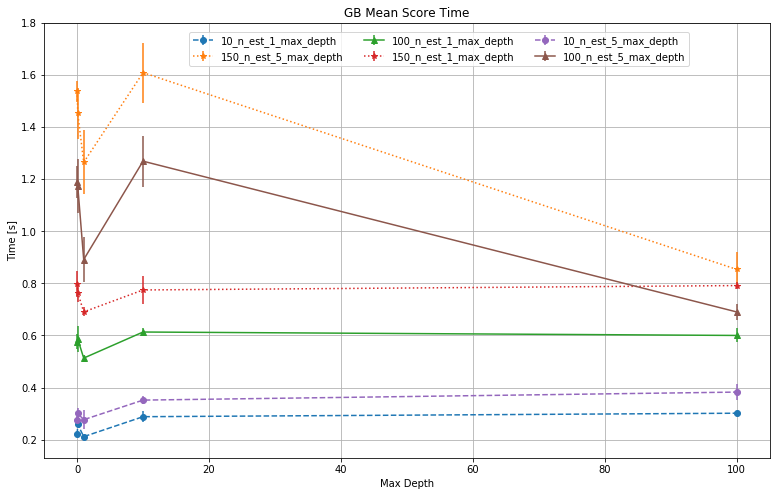

In [0]:
import ast
def fill_params(parameters, n_est, md, t, p, s):
    try:
        parameters['{}_n_est_{}_max_depth'.format(n_est, md)]['time'].append(t)
        parameters['{}_n_est_{}_max_depth'.format(n_est, md)]['d'].append(p['learning_rate'])
        parameters['{}_n_est_{}_max_depth'.format(n_est, md)]['std'].append(s)
    except KeyError:
        parameters['{}_n_est_{}_max_depth'.format(n_est, md)] = {'time': [], 'd': [], 'std': []}
        parameters['{}_n_est_{}_max_depth'.format(n_est, md)]['time'].append(t)
        parameters['{}_n_est_{}_max_depth'.format(n_est, md)]['d'].append(p['learning_rate'])
        parameters['{}_n_est_{}_max_depth'.format(n_est, md)]['std'].append(s)

mean_fit_time = grid_result['mean_score_time']
std_fit_time = grid_result['std_score_time']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_fit_time, params, std_fit_time):
    p = ast.literal_eval(p)
    if p['n_estimators'] == 10:
        if p['max_depth'] == 1:
            fill_params(parameters, 10, 1, t, p, s)
        elif p['max_depth'] == 5:
            fill_params(parameters, 10, 5, t, p, s)
    elif p['n_estimators'] == 100:
        if p['max_depth'] == 1:
            fill_params(parameters, 100, 1, t, p, s)
        elif p['max_depth'] == 5:
            fill_params(parameters, 100, 5, t, p, s)
    elif p['n_estimators'] == 150:
        if p['max_depth'] == 1:
            fill_params(parameters, 150, 1, t, p, s)
        elif p['max_depth'] == 5:
            fill_params(parameters, 150, 5, t, p, s)
            
fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('GB Mean Score Time')
for key, value in parameters.items():
    if '10_n_' in key:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='o', linestyle='--')
    elif '100_n_' in key:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='^', linestyle='-')
    else:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='*', linestyle=':')
ax.set_ylabel('Time [s]')
ax.set_xlabel('Max Depth')
ax.grid(True)
ax.legend(ncol=3, loc=[0.2, 0.9])

# GB neg log loss

In [0]:
learning_rate = [0.01, 0.1, 1.0, 10.0, 100.0]
n_estimators = [10, 100, 150]
max_depth = [1, 5]

                                                         
num_fold = 5
seed = 7
scoring = 'neg_log_loss'
param_grid = {'learning_rate': learning_rate, 'n_estimators': n_estimators, 'max_depth': max_depth}
print(pipelines[7][0])
model = pipelines[7][1] # Gradient Boosting model
kfold = KFold(n_splits=num_fold, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)
grid_result = grid.fit(training, y_training)
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format(mean, stdev, param))
pd.DataFrame(grid_result.cv_results_).to_csv('GB_nll.csv')
grid_result = pd.read_csv('GB_nll.csv')

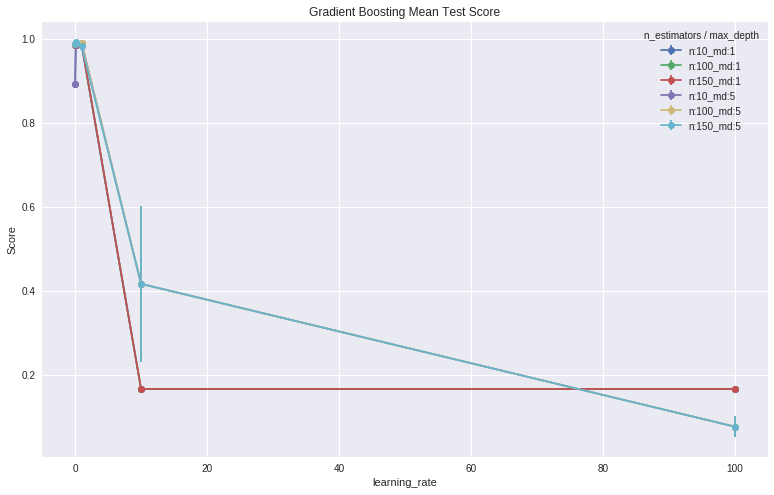

In [0]:
import ast
grid_result = pd.read_csv('GB_acc.csv')
def fill_params(parameters, n, md, t, p, s):
    try:
        parameters['n:{}_md:{}'.format(n, md)]['score'].append(t)
        parameters['n:{}_md:{}'.format(n, md)]['learning_rate'].append(p['learning_rate'])
        parameters['n:{}_md:{}'.format(n, md)]['std'].append(s)
    except KeyError:
        parameters['n:{}_md:{}'.format(n, md)] = {'score': [], 'learning_rate': [], 'std': []}
        parameters['n:{}_md:{}'.format(n, md)]['score'].append(t)
        parameters['n:{}_md:{}'.format(n, md)]['learning_rate'].append(p['learning_rate'])
        parameters['n:{}_md:{}'.format(n, md)]['std'].append(s)

mean_test_score = grid_result['mean_test_score']
std_test_score = grid_result['std_test_score']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_test_score, params, std_test_score):
    p = ast.literal_eval(p)
    fill_params(parameters, p['n_estimators'], p['max_depth'], t, p, s)

fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('Gradient Boosting Mean Test Score')
for key, value in parameters.items():
    ax.errorbar(value['learning_rate'], value['score'], value['std'], label=key, marker='o', linestyle='-')
ax.set_ylabel('Score')
ax.set_xlabel('learning_rate')
ax.grid(True)
ax.legend(title='n_estimators / max_depth')

In [0]:
import ast
grid_result = pd.read_csv('GB_acc.csv')
def fill_params(parameters, n, md, t, p, s):
    try:
        parameters['n:{}_md:{}'.format(n, md)]['score'].append(t)
        parameters['n:{}_md:{}'.format(n, md)]['learning_rate'].append(p['learning_rate'])
        parameters['n:{}_md:{}'.format(n, md)]['std'].append(s)
    except KeyError:
        parameters['n:{}_md:{}'.format(n, md)] = {'score': [], 'learning_rate': [], 'std': []}
        parameters['n:{}_md:{}'.format(n, md)]['score'].append(t)
        parameters['n:{}_md:{}'.format(n, md)]['learning_rate'].append(p['learning_rate'])
        parameters['n:{}_md:{}'.format(n, md)]['std'].append(s)

mean_test_score = grid_result['mean_test_score']
std_test_score = grid_result['std_test_score']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_test_score, params, std_test_score):
    p = ast.literal_eval(p)
    fill_params(parameters, p['n_estimators'], p['max_depth'], t, p, s)

fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('Gradient Boosting Mean Test Score')
for key, value in parameters.items():
    ax.errorbar(value['learning_rate'], value['score'], value['std'], label=key, marker='o', linestyle='-')
ax.set_ylabel('Score')
ax.set_xlabel('learning_rate')
ax.grid(True)
ax.legend(title='n_estimators / max_depth')

# ET acc

In [0]:
max_depth = [10, 40, 70, 100]
n_estimators = [200, 800, 1400, 2000]
                                                         
num_fold = 5
seed = 7
scoring = 'accuracy'
param_grid = {'max_depth': max_depth, 'n_estimators': n_estimators}
print(pipelines[9][0])
model = pipelines[9][1] # Gradient Boosting model
kfold = KFold(n_splits=num_fold, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(training, y_training)
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format(mean, stdev, param))
pd.DataFrame(grid_result.cv_results_).to_csv('ET_acc.csv')
grid_result = pd.read_csv('ET_acc.csv')

ET


In [0]:
grid_result = pd.read_csv('ET_acc.csv')

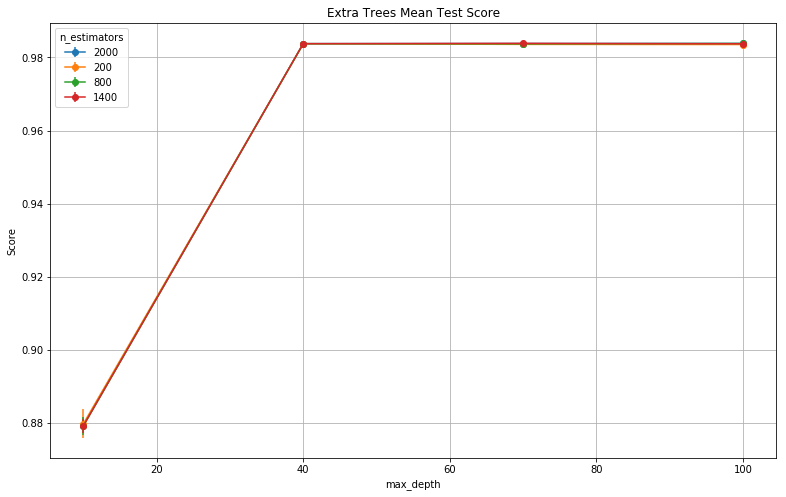

In [0]:
import ast
def fill_params(parameters, n, t, p, s):
    try:
        parameters['{}'.format(n)]['score'].append(t)
        parameters['{}'.format(n)]['max_depth'].append(p['max_depth'])
        parameters['{}'.format(n)]['std'].append(s)
    except KeyError:
        parameters['{}'.format(n)] = {'score': [], 'max_depth': [], 'std': []}
        parameters['{}'.format(n)]['score'].append(t)
        parameters['{}'.format(n)]['max_depth'].append(p['max_depth'])
        parameters['{}'.format(n)]['std'].append(s)

mean_test_score = grid_result['mean_test_score']
std_test_score = grid_result['std_test_score']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_test_score, params, std_test_score):
    p = ast.literal_eval(p)
    fill_params(parameters, p['n_estimators'], t, p, s)

fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('Extra Trees Mean Test Score')
for key, value in parameters.items():
    ax.errorbar(value['max_depth'], value['score'], value['std'], label=key, marker='o', linestyle='-')
ax.set_ylabel('Score')
ax.set_xlabel('max_depth')
ax.grid(True)
ax.legend(title='n_estimators')

In [0]:
params = grid_result['params']
params

0       {'max_depth': 10, 'n_estimators': 200}
1       {'max_depth': 10, 'n_estimators': 800}
2      {'max_depth': 10, 'n_estimators': 1400}
3      {'max_depth': 10, 'n_estimators': 2000}
4       {'max_depth': 40, 'n_estimators': 200}
5       {'max_depth': 40, 'n_estimators': 800}
6      {'max_depth': 40, 'n_estimators': 1400}
7      {'max_depth': 40, 'n_estimators': 2000}
8       {'max_depth': 70, 'n_estimators': 200}
9       {'max_depth': 70, 'n_estimators': 800}
10     {'max_depth': 70, 'n_estimators': 1400}
11     {'max_depth': 70, 'n_estimators': 2000}
12     {'max_depth': 100, 'n_estimators': 200}
13     {'max_depth': 100, 'n_estimators': 800}
14    {'max_depth': 100, 'n_estimators': 1400}
15    {'max_depth': 100, 'n_estimators': 2000}
Name: params, dtype: object

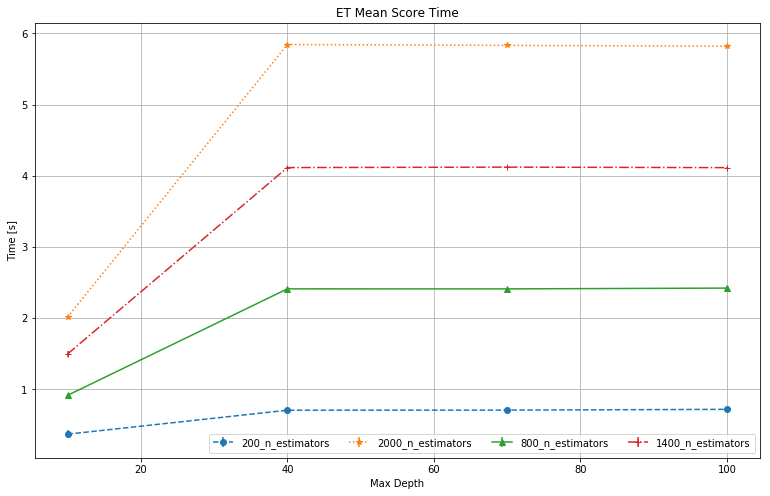

In [0]:
import ast
def fill_params(parameters, depth, est, t, p, s):
    try:
        parameters['{}_n_estimators'.format(est)]['time'].append(t)
        parameters['{}_n_estimators'.format(est)]['d'].append(p['max_depth'])
        parameters['{}_n_estimators'.format(est)]['std'].append(s)
    except KeyError:
        parameters['{}_n_estimators'.format(est)] = {'time': [], 'd': [], 'std': []}
        parameters['{}_n_estimators'.format(est)]['time'].append(t)
        parameters['{}_n_estimators'.format(est)]['d'].append(p['max_depth'])
        parameters['{}_n_estimators'.format(est)]['std'].append(s)

mean_score_time = grid_result['mean_score_time']
std_score_time = grid_result['std_score_time']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_score_time, params, std_score_time):
    p = ast.literal_eval(p)
    if p['max_depth'] == 10:
        if p['n_estimators'] == 200:
            fill_params(parameters, 10, 200, t, p, s)
        elif p['n_estimators'] == 800:
            fill_params(parameters, 10, 800, t, p, s)
        elif p['n_estimators'] == 1400:
            fill_params(parameters, 10, 1400, t, p, s)
        elif p['n_estimators'] == 2000:
            fill_params(parameters, 10, 2000, t, p, s)
    elif p['max_depth'] == 40:
        if p['n_estimators'] == 200:
            fill_params(parameters, 40, 200, t, p, s)
        elif p['n_estimators'] == 800:
            fill_params(parameters, 40, 800, t, p, s)
        elif p['n_estimators'] == 1400:
            fill_params(parameters, 40, 1400, t, p, s)
        elif p['n_estimators'] == 2000:
            fill_params(parameters, 40, 2000, t, p, s)
    elif p['max_depth'] == 70:
        if p['n_estimators'] == 200:
            fill_params(parameters, 70, 200, t, p, s)
        elif p['n_estimators'] == 800:
            fill_params(parameters, 70, 800, t, p, s)
        elif p['n_estimators'] == 1400:
            fill_params(parameters, 70, 1400, t, p, s)
        elif p['n_estimators'] == 2000:
            fill_params(parameters, 70, 2000, t, p, s)
    else:
        if p['n_estimators'] == 200:
            fill_params(parameters, 200, 200, t, p, s)
        elif p['n_estimators'] == 800:
            fill_params(parameters, 200, 800, t, p, s)
        elif p['n_estimators'] == 1400:
            fill_params(parameters, 200, 1400, t, p, s)
        elif p['n_estimators'] == 2000:
            fill_params(parameters, 200, 2000, t, p, s)
        
fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('ET Mean Score Time')
for key, value in parameters.items():
    if '200_' in key:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='o', linestyle='--')
    elif '800_' in key:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='^', linestyle='-')
    elif '1400_' in key:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='+', linestyle='-.')
    else:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='*', linestyle=':')
ax.set_ylabel('Time [s]')
ax.set_xlabel('Max Depth')
ax.grid(True)
ax.legend(ncol=6)

In [0]:
grid_result.columns

Index(['Unnamed: 0', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
       'std_score_time', 'param_max_depth', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

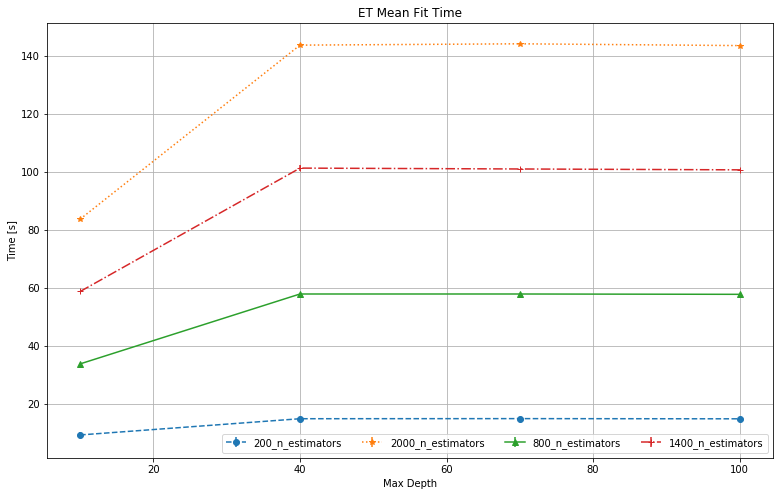

In [0]:
import ast
def fill_params(parameters, depth, est, t, p, s):
    try:
        parameters['{}_n_estimators'.format(est)]['time'].append(t)
        parameters['{}_n_estimators'.format(est)]['d'].append(p['max_depth'])
        parameters['{}_n_estimators'.format(est)]['std'].append(s)
    except KeyError:
        parameters['{}_n_estimators'.format(est)] = {'time': [], 'd': [], 'std': []}
        parameters['{}_n_estimators'.format(est)]['time'].append(t)
        parameters['{}_n_estimators'.format(est)]['d'].append(p['max_depth'])
        parameters['{}_n_estimators'.format(est)]['std'].append(s)

mean_score_time = grid_result['mean_fit_time']
std_score_time = grid_result['std_fit_time']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_score_time, params, std_score_time):
    p = ast.literal_eval(p)
    if p['max_depth'] == 10:
        if p['n_estimators'] == 200:
            fill_params(parameters, 10, 200, t, p, s)
        elif p['n_estimators'] == 800:
            fill_params(parameters, 10, 800, t, p, s)
        elif p['n_estimators'] == 1400:
            fill_params(parameters, 10, 1400, t, p, s)
        elif p['n_estimators'] == 2000:
            fill_params(parameters, 10, 2000, t, p, s)
    elif p['max_depth'] == 40:
        if p['n_estimators'] == 200:
            fill_params(parameters, 40, 200, t, p, s)
        elif p['n_estimators'] == 800:
            fill_params(parameters, 40, 800, t, p, s)
        elif p['n_estimators'] == 1400:
            fill_params(parameters, 40, 1400, t, p, s)
        elif p['n_estimators'] == 2000:
            fill_params(parameters, 40, 2000, t, p, s)
    elif p['max_depth'] == 70:
        if p['n_estimators'] == 200:
            fill_params(parameters, 70, 200, t, p, s)
        elif p['n_estimators'] == 800:
            fill_params(parameters, 70, 800, t, p, s)
        elif p['n_estimators'] == 1400:
            fill_params(parameters, 70, 1400, t, p, s)
        elif p['n_estimators'] == 2000:
            fill_params(parameters, 70, 2000, t, p, s)
    else:
        if p['n_estimators'] == 200:
            fill_params(parameters, 200, 200, t, p, s)
        elif p['n_estimators'] == 800:
            fill_params(parameters, 200, 800, t, p, s)
        elif p['n_estimators'] == 1400:
            fill_params(parameters, 200, 1400, t, p, s)
        elif p['n_estimators'] == 2000:
            fill_params(parameters, 200, 2000, t, p, s)
        
fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('ET Mean Fit Time')
for key, value in parameters.items():
    if '200_' in key:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='o', linestyle='--')
    elif '800_' in key:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='^', linestyle='-')
    elif '1400_' in key:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='+', linestyle='-.')
    else:
        ax.errorbar(value['d'], value['time'], value['std'], label=key, marker='*', linestyle=':')
ax.set_ylabel('Time [s]')
ax.set_xlabel('Max Depth')
ax.grid(True)
ax.legend(ncol=6)

# ET neg log loss

In [0]:
max_depth = [10, 40, 70, 100]
n_estimators = [200, 800, 1400, 2000]
                                                         
num_fold = 5
seed = 7
scoring = 'neg_log_loss'
param_grid = {'max_depth': max_depth, 'n_estimators': n_estimators}
print(pipelines[9][0])
model = pipelines[9][1] # Gradient Boosting model
kfold = KFold(n_splits=num_fold, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(training, y_training)
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format(mean, stdev, param))
pd.DataFrame(grid_result.cv_results_).to_csv('ET_nll.csv')
grid_result = pd.read_csv('ET_nll.csv')

In [0]:
grid_result = pd.read_csv('ET_nll.csv')

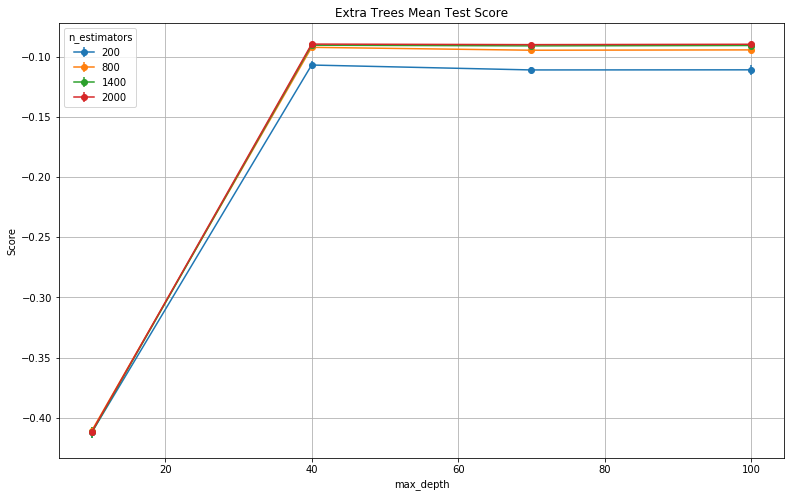

In [0]:
import ast
def fill_params(parameters, n, t, p, s):
    try:
        parameters['{}'.format(n)]['score'].append(t)
        parameters['{}'.format(n)]['max_depth'].append(p['max_depth'])
        parameters['{}'.format(n)]['std'].append(s)
    except KeyError:
        parameters['{}'.format(n)] = {'score': [], 'max_depth': [], 'std': []}
        parameters['{}'.format(n)]['score'].append(t)
        parameters['{}'.format(n)]['max_depth'].append(p['max_depth'])
        parameters['{}'.format(n)]['std'].append(s)

mean_test_score = grid_result['mean_test_score']
std_test_score = grid_result['std_test_score']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_test_score, params, std_test_score):
    p = ast.literal_eval(p)
    fill_params(parameters, p['n_estimators'], t, p, s)

fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('Extra Trees Mean Test Score')
for key, value in parameters.items():
    ax.errorbar(value['max_depth'], value['score'], value['std'], label=key, marker='o', linestyle='-')
ax.set_ylabel('Score')
ax.set_xlabel('max_depth')
ax.grid(True)
ax.legend(title='n_estimators')

# XGB neg log loss

In [0]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
param_grid = {
    'max_depth': [2,4,6,8,10,12,14],
    'learning_rate': [1.0],
    'n_estimators': [1000],
#     'gamma': [0],
    'min_child_weight': [1,2,3,4,5,6,7,8,9,15],
#     'subsample': [0.8],
#     'colsample_bytree': [0.8],
    'seed': [7],
#     'scale_pos_weight': [1],
    'n_jobs': [-1],
}
    
num_fold = 5
seed = 7
scoring = 'neg_log_loss'
# param_grid = {'learning_rate': learning_rate, 'n_estimators': n_estimators, 'max_depth': max_depth}
print(pipelines[10][0])
model = pipelines[10][1] # Gradient Boosting model
kfold = KFold(n_splits=num_fold, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)
grid_result = grid.fit(training, y_training)
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format(mean, stdev, param))

XGB


In [0]:
pd.DataFrame(grid_result.cv_results_).to_csv('XGB_maxdepth_child_weight_nll.csv')

In [0]:
grid_result = pd.read_csv('XGB_maxdepth_child_weight_nll.csv')

In [0]:
import ast
grid_result = grid_result.cv_results_
def fill_params(parameters, mcw, t, p, s):
    try:
        parameters['{}'.format(mcw)]['score'].append(t)
        parameters['{}'.format(mcw)]['max_depth'].append(p['max_depth'])
        parameters['{}'.format(mcw)]['std'].append(s)
    except KeyError:
        parameters['{}'.format(mcw)] = {'score': [], 'max_depth': [], 'std': []}
        parameters['{}'.format(mcw)]['score'].append(t)
        parameters['{}'.format(mcw)]['max_depth'].append(p['max_depth'])
        parameters['{}'.format(mcw)]['std'].append(s)

mean_test_score = grid_result['mean_test_score']
std_test_score = grid_result['std_test_score']
params = grid_result['params']
parameters = {}
for t, p, s in zip(mean_test_score, params, std_test_score):
#     p = ast.literal_eval(p)
    fill_params(parameters, p['min_child_weight'], t, p, s)

fig, ax = plt.subplots(1,1, figsize=(13,8))
ax.set_title('XGB Mean Test Score')
for key, value in parameters.items():
    ax.errorbar(value['max_depth'], value['score'], value['std'], label=key, marker='o', linestyle='-')
ax.set_ylabel('Score')
ax.set_xlabel('max_depth')
ax.grid(True)
ax.legend(title='min_child_weight')

In [0]:
param_grid = {
    'max_depth': [8],
    'learning_rate': [1.0],
    'n_estimators': [1000],
    'n_jobs': [4],
    'gamma': [0.0, 0.1, 0.2, 0.25, 0.3, 0.4, 0.45, 0.5, 0.6, 0.65, 0.7, 0.8, 0.9],
    'min_child_weight': [2],
#     'subsample': [0.8],
#     'colsample_bytree': [0.8],
    'seed': [7],
#     'scale_pos_weight': [1]
}

num_fold = 5
seed = 7
scoring = 'accuracy'
# param_grid = {'learning_rate': learning_rate, 'n_estimators': n_estimators, 'max_depth': max_depth}
print(pipelines[10][0])
model = pipelines[10][1] # Gradient Boosting model
kfold = KFold(n_splits=num_fold, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(training, y_training)
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format(mean, stdev, param))
pd.DataFrame(grid_result.cv_results_).to_csv('XGB_gamma_nll.csv')
grid_result = pd.read_csv('XGB_gamma_nll.csv')

# SVM

In [0]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

param_grid = {
    'SVM__C': [0.1, 1.0, 2.0, 10],
    'SVM__gamma': [0.1, 1.0, 10]
}
    
num_fold = 5
seed = 7
scoring = 'accuracy'
# param_grid = {'learning_rate': learning_rate, 'n_estimators': n_estimators, 'max_depth': max_depth}
print(pipelines[5][0])
model = pipelines[5][1] # Gradient Boosting model
kfold = KFold(n_splits=num_fold, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)
grid_result = grid.fit(training, y_training)
print("Best: {} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{} ({}) with: {}".format(mean, stdev, param))

In [0]:
pd.DataFrame(grid_result.cv_results_).to_csv('SVM_acc.csv')
grid_result = pd.read_csv('SVM_acc.csv')

# Neural Network

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras import callbacks
from sklearn.preprocessing import StandardScaler

## Manual NN hyperparameter optimization

In [0]:
# # encode class values as integers
# encoder = LabelEncoder()
# encoder.fit(y_training)
# encoded_Y = encoder.transform(y_training)
# # convert integers to dummy variables (i.e. one hot encoded)
# dummy_y = np_utils.to_categorical(encoded_Y)

# # encode class values as integers
# encoder2 = LabelEncoder()
# encoder2.fit(y_valid)
# encoded_Y = encoder2.transform(y_valid)
# # convert integers to dummy variables (i.e. one hot encoded)
# dummy_y2 = np_utils.to_categorical(encoded_Y)

# define baseline model
def baseline_model(activation=['relu'], n_neurons=[10], n_hidden_layers = 1, dropaout=[0.01], optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(n_neurons[0], input_dim=training.shape[1], activation=activation[0]))
    model.add(Dropout(dropaout[0]))
    if n_hidden_layers > 1:
        for i in range(1, n_hidden_layers):
            model.add(Dense(n_neurons[i]))
            model.add(Dropout(dropaout[i]))
    model.add(Dense(y_training_dummy.shape[1], activation='relu'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
    return model
es = callbacks.EarlyStopping(monitor='val_loss',
                                      min_delta=0.008,
                                      patience=15,
                                      verbose=1, mode='auto')

# model = baseline_model(activation=['relu'], n_neurons=[100, 500, 30], n_hidden_layers = 1, dropaout=[0.4, 0.2, 0.4], optimizer='adam')
scaler = StandardScaler()
history = []
parameters = [{'n_hidden_layers': 1, 'n_neurons': [100], 'dropaout': [0.2]},
              {'n_hidden_layers': 2, 'n_neurons': [300, 200], 'dropaout': [0.2, 0.3]},
              {'n_hidden_layers': 3, 'n_neurons': [300, 200, 100], 'dropaout': [0.2, 0.3, 0.1]},
              {'n_hidden_layers': 4, 'n_neurons': [400, 300, 200, 100], 'dropaout': [0.2, 0.3, 0.1, 0.1]}]
bs = [64, 128, 256, 512]
for i in parameters:
    for s in bs:
        model = baseline_model(activation=['relu'], 
                               n_neurons=i['n_neurons'], 
                               n_hidden_layers = i['n_hidden_layers'], 
                               dropaout=i['dropaout'], 
                               optimizer='adam')
        if i['n_hidden_layers'] == 4:
            history.append({'batch_size': s, 
                        'n_hidden_layers': i['n_hidden_layers'],
                        'history': model.fit(scaler.fit_transform(training.values), 
                                             y_training_dummy, 
                                             batch_size=s, 
                                             nb_epoch=200, 
                                             verbose=1, 
                                             validation_data=(scaler.transform(valid.values), y_valid_dummy), 
                                             callbacks=[es])})
        else:
            history.append({'batch_size': s, 
                            'n_hidden_layers': i['n_hidden_layers'],
                            'history': model.fit(scaler.fit_transform(training.values), 
                                                 y_training_dummy, 
                                                 batch_size=s, 
                                                 nb_epoch=200, 
                                                 verbose=1, 
                                                 validation_data=(scaler.transform(valid.values), y_valid_dummy), 
                                                 callbacks=[es])})

In [0]:
import pickle
filename = 'NN_history_more.sav'
pickle.dump(history, open(filename, 'wb'))

In [0]:
for i in range(len(history)):
    history[i]['history'] = history[i]['history'].history
history

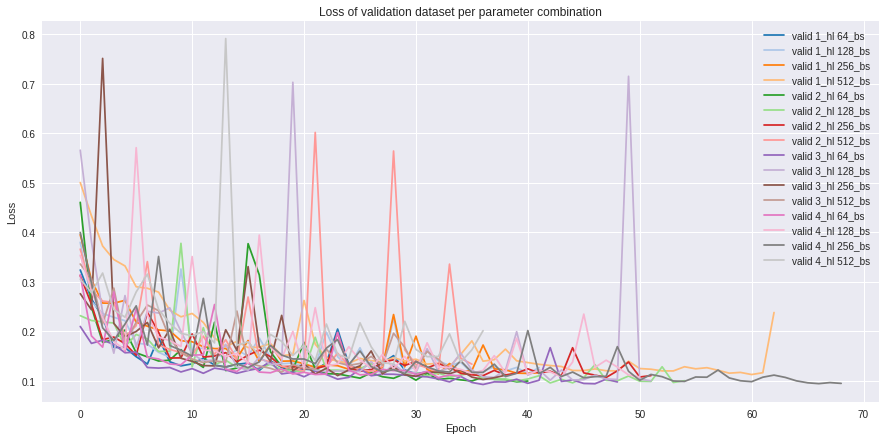

In [0]:
colors = [matplotlib.colors.rgb2hex(i) for i in plt.get_cmap('magma').colors][50:100]
colors = plt.get_cmap('tab20').colors
loss = plt.figure(figsize=(15,7))
for i in range(len(history)):
#     loss = plt.figure(figsize=(15,7))
#     plt.plot(history[i]['history']['loss'], 
#              label='train {}_hl {}_bs'.format(history[i]['n_hidden_layers'], history[i]['batch_size']),
#              linestyle='-.')
    plt.plot(history[i]['history']['val_loss'], 
             label='valid {}_hl {}_bs'.format(history[i]['n_hidden_layers'], history[i]['batch_size']),
             color=colors[i])
    plt.title("Loss of validation dataset per parameter combination")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

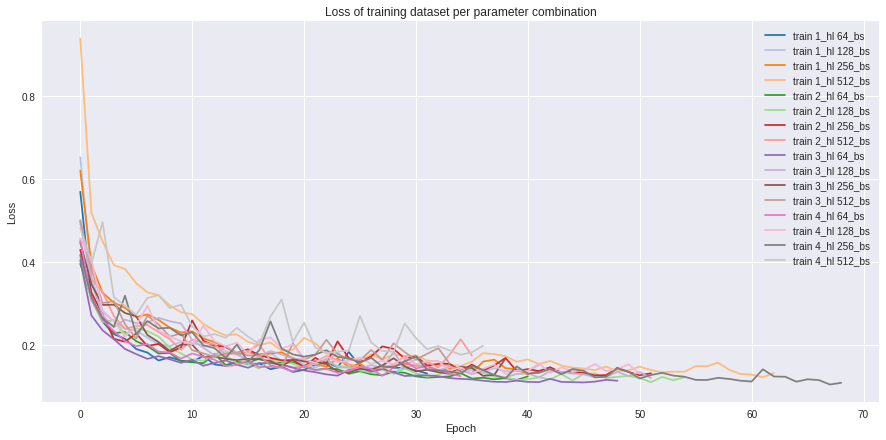

In [0]:
colors = [matplotlib.colors.rgb2hex(i) for i in plt.get_cmap('magma').colors][50:100]
colors = plt.get_cmap('tab20').colors
loss = plt.figure(figsize=(15,7))
for i in range(len(history)):
#     loss = plt.figure(figsize=(15,7))
    plt.plot(history[i]['history']['loss'], 
             label='train {}_hl {}_bs'.format(history[i]['n_hidden_layers'], history[i]['batch_size']),
             color=colors[i])
#     plt.plot(history[i]['history']['val_loss'], 
#              label='valid {}_hl {}_bs'.format(history[i]['n_hidden_layers'], history[i]['batch_size']),
#              color=colors[i])
    plt.title("Loss of training dataset per parameter combination")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

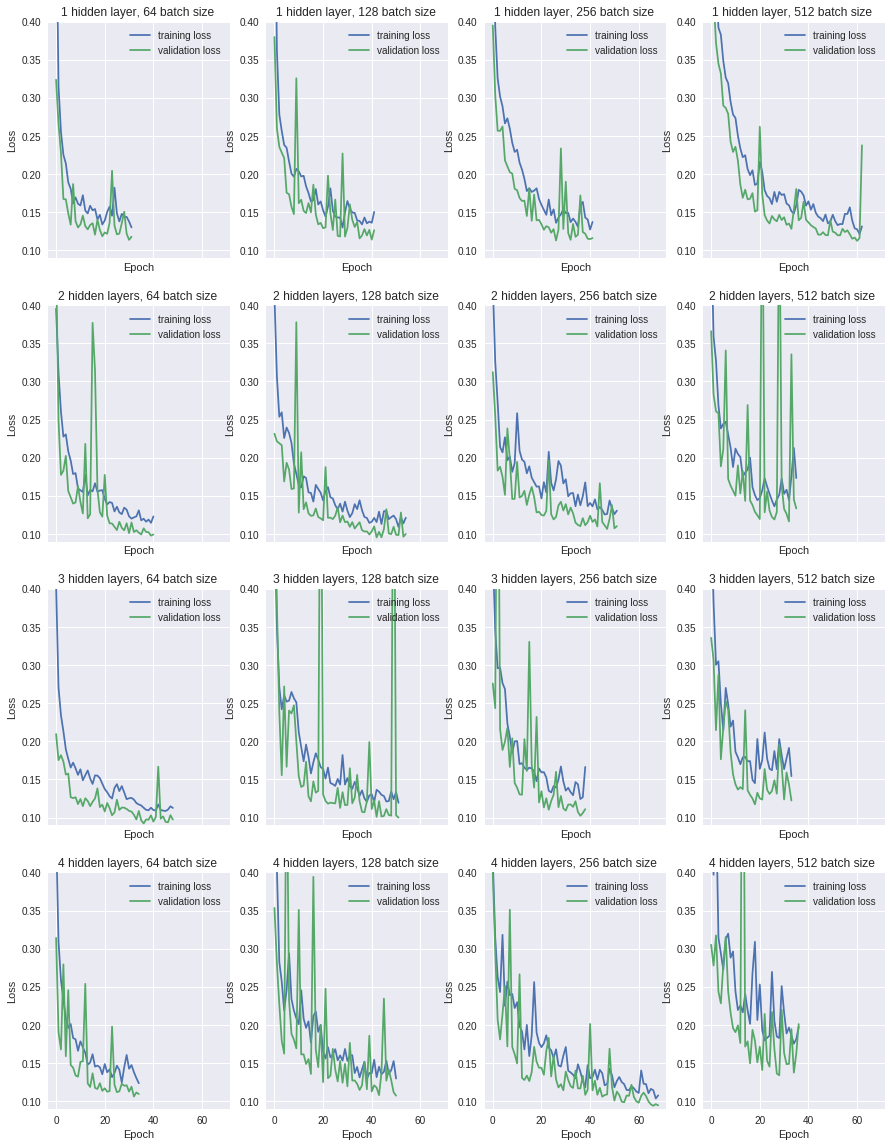

In [0]:
fig, axs = plt.subplots(4, 4, sharex=True, figsize=(15,20))
i = 0
for ax in axs:
    for val in ax:
        val.plot(history[i]['history']['loss'], label='training loss')
        val.plot(history[i]['history']['val_loss'], label='validation loss')
        if history[i]['n_hidden_layers'] == 1:
            val.set_title("{} hidden layer, {} batch size ".format(history[i]['n_hidden_layers'], history[i]['batch_size']))
        else:
            val.set_title("{} hidden layers, {} batch size ".format(history[i]['n_hidden_layers'], history[i]['batch_size']))
        val.set_ylabel('Loss')
        val.set_xlabel('Epoch')
        val.set_ylim([0.09, 0.4])
        val.legend(loc='upper right')
        i += 1

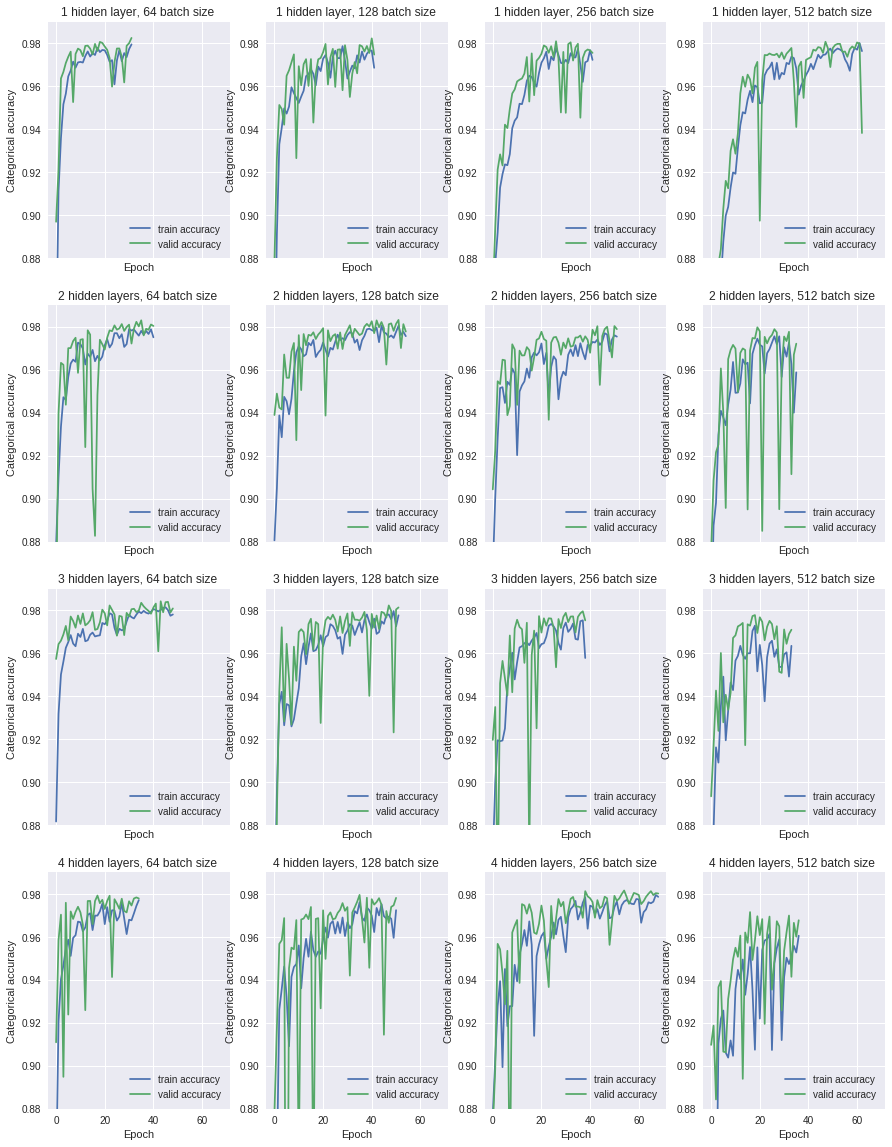

In [0]:
fig, axs = plt.subplots(4, 4, sharex=True, figsize=(15,20))
i = 0
for ax in axs:
    for val in ax:
        val.plot(history[i]['history']['categorical_accuracy'], label='train accuracy')
        val.plot(history[i]['history']['val_categorical_accuracy'], label='valid accuracy')
        if history[i]['n_hidden_layers'] == 1:
            val.set_title("{} hidden layer, {} batch size ".format(history[i]['n_hidden_layers'], history[i]['batch_size']))
        else:
            val.set_title("{} hidden layers, {} batch size ".format(history[i]['n_hidden_layers'], history[i]['batch_size']))
        val.set_ylabel('Categorical accuracy')
        val.set_xlabel('Epoch')
        val.set_ylim([0.88,0.99])
        val.legend(loc='lower right')
        i += 1

In [0]:
def baseline_model(activation=['relu'], n_neurons=[400, 300, 200, 100], n_hidden_layers = 4, dropaout=[0.2, 0.3, 0.1, 0.1], optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(n_neurons[0], input_dim=training.shape[1], activation=activation[0]))
    model.add(Dropout(dropaout[0]))
    if n_hidden_layers > 1:
        for i in range(1, n_hidden_layers):
            model.add(Dense(n_neurons[i]))
            model.add(Dropout(dropaout[i]))
    model.add(Dense(y_training_dummy.shape[1], activation='relu'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
    return model

In [0]:
training.head()

,ra,dec,u,g,r,i,z,run,camcol,field,specobjid,redshift,plate,mjd,fiberid
0,217.277996,37.718993,18.38985,17.35734,16.99446,16.79452,16.66337,8.266935,3.0,5.834811,41.887948,0.034111,7.230563,53089.0,148.0
1,181.254227,11.512677,18.38431,17.13049,17.31714,17.42732,17.50734,8.252185,1.0,5.375278,42.732645,0.000660,8.075272,54866.0,191.0
2,154.952990,9.011544,19.11709,18.22705,17.94158,17.90282,17.88869,8.165648,4.0,4.564348,42.714143,0.000856,8.056744,54829.0,521.0
3,172.332359,52.124131,19.37596,18.22277,17.69184,17.37288,17.25970,7.966587,4.0,5.003946,41.436285,0.047974,6.778785,52365.0,507.0
4,212.204549,55.637139,19.36175,17.50535,16.61090,16.20069,15.87760,8.217439,6.0,4.553877,41.845879,0.073969,7.188413,53088.0,579.0


## NN SHAP explenation

Epoch 1/65
4000/4000 [==============================] - 1s 134us/step - loss: 1.2630 - categorical_accuracy: 0.7195
Epoch 2/65
4000/4000 [==============================] - 0s 23us/step - loss: 0.6026 - categorical_accuracy: 0.8205
Epoch 3/65
4000/4000 [==============================] - 0s 24us/step - loss: 0.5060 - categorical_accuracy: 0.8297
Epoch 4/65
4000/4000 [==============================] - 0s 24us/step - loss: 0.4671 - categorical_accuracy: 0.8460
Epoch 5/65
4000/4000 [==============================] - 0s 24us/step - loss: 0.5238 - categorical_accuracy: 0.8502
Epoch 6/65
4000/4000 [==============================] - 0s 24us/step - loss: 0.5093 - categorical_accuracy: 0.8595
Epoch 7/65
4000/4000 [==============================] - 0s 24us/step - loss: 0.4750 - categorical_accuracy: 0.8665
Epoch 8/65
4000/4000 [==============================] - 0s 25us/step - loss: 0.4114 - categorical_accuracy: 0.8743
Epoch 9/65
4000/4000 [==============================] - 0s 25us/step - loss: 0.

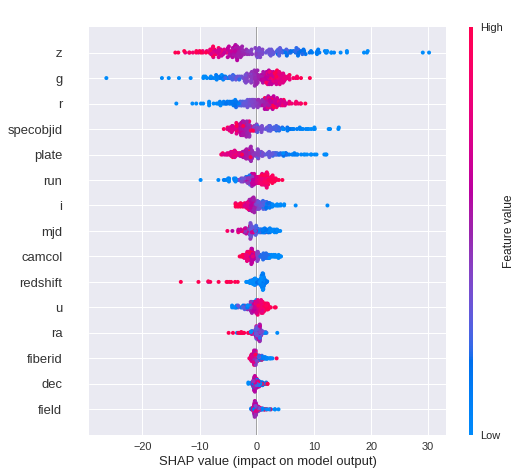

In [0]:
import shap
shap.initjs()
scaler = StandardScaler()
model = baseline_model()
model.fit(scaler.fit_transform(training.values), y_training_dummy, epochs=65, batch_size=256, verbose=1)

# explain predictions of the model on four images
e = shap.DeepExplainer(model, scaler.fit_transform(training.values[0:200,:]))
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(scaler.fit_transform(training.values[0:200,:]))

shap.summary_plot(shap_values[0], training.iloc[0:200,:])

## Neural Network Confusion matrix and classification report

In [0]:
model = baseline_model()
model.fit(scaler.fit_transform(training.values), y_training_dummy, epochs=65, batch_size=256, verbose=1)

In [0]:
predictions = model.predict_classes(scaler.transform(test.values))
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y_test = encoder.transform(y_test)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
print(accuracy_score(encoded_Y_test, predictions))
print(confusion_matrix(encoded_Y_test, predictions))
print(classification_report(encoded_Y_test, predictions))

0.9799
[[53330   211  1085]
 [  646  9666     7]
 [   56     5 34994]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     54626
           1       0.98      0.94      0.96     10319
           2       0.97      1.00      0.98     35055

   micro avg       0.98      0.98      0.98    100000
   macro avg       0.98      0.97      0.97    100000
weighted avg       0.98      0.98      0.98    100000



[[53330   211  1085]
 [  646  9666     7]
 [   56     5 34994]]


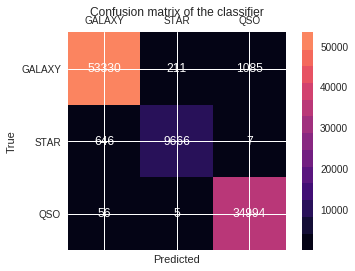

In [0]:
from matplotlib.colors import ListedColormap
colors = ListedColormap(plt.get_cmap('magma').colors[10:200:15])
labels = ['GALAXY', 'STAR', 'QSO']
cm = confusion_matrix(encoded_Y_test, predictions)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=colors)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
for i in range(len(cm)):
    for j in range(len(cm)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

## Neural Network computation of metrices per training dataset size

In [0]:
# how many rows entire dataset has
n_rows, n_cols = dataset.shape
# get column names and change order
columns = dataset.columns.tolist()
del columns[12]
columns.append('class')
# check if dataset consists of empty values
columns_missing = [col for col in dataset.columns if dataset[col].isnull().any()]
if columns_missing:
    print("Dataset has missing values in the following columns:\n{}".format(columns_missing))
else:
    print("Dataset do not has any column with empty value.")
# split data accordingly:
# test data: 30% of entire dataset
X = dataset.drop(['class'], axis=1).values
Y = dataset['class'].values
# encode class values as integers

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
#test size poczatkowe to 0.2

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.99, random_state=0)
for train_index, test_index in sss.split(X, Y):
    train, test = X[train_index], X[test_index]
    y_train_dummy, y_test_dummy = dummy_y[train_index], dummy_y[test_index]
    y_train, y_test = Y[train_index], Y[test_index]   

# split data into training and validation
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
for train_index, valid_index in sss.split(train, y_train):
    training, valid = train[train_index], train[valid_index]
    y_training_dummy, y_valid_dummy = y_train_dummy[train_index], y_train_dummy[valid_index]
    y_training, y_valid = y_train[train_index], y_train[valid_index] 
    
training = pd.DataFrame(data=training, columns=dataset.drop(['class'], axis=1).columns.values)
valid = pd.DataFrame(data=valid, columns=dataset.drop(['class'], axis=1).columns.values)
test = pd.DataFrame(data=test, columns=dataset.drop(['class'], axis=1).columns.values)

training['specobjid'] = np.log(training['specobjid'])
training['field'] = np.log(training['field'])
training['run'] = np.log(training['run'])
training['plate'] = np.log(training['plate'])

training = training.drop(['rerun'], axis=1)

# model = baseline_model()

# X_train = X_train.values

Dataset do not has any column with empty value.


In [0]:
training.shape

(80000, 15)

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
scaler = StandardScaler()
model = KerasClassifier(build_fn=baseline_model, epochs=65, batch_size=256, verbose=0)
num_fold = 5
seed = 7
scoring = 'f1_weighted'
results = []
names = []
# k-fld test, produce extimated score per algorithm based on training and validation datasets
kfold = StratifiedKFold(n_splits=num_fold, random_state=seed)
cv_results = cross_validate(model, 
                             scaler.fit_transform(training.values), 
                             y_training, cv=kfold, 
                             scoring=scoring, 
                             fit_params={'epochs':65, 
                                         'batch_size':256, 
                                         'verbose':0})
# results.append(cv_results)
# names.append('NN')
print('fit time: {} {}'.format(np.mean(cv_results['fit_time'])/6400, np.std(cv_results['fit_time'])/6400))
print('score time: {} {}'.format(np.mean(cv_results['score_time'])/1600, np.std(cv_results['score_time'])/1600))
# msg = "{}: {} ({})".format('NN', cv_results.mean(), cv_results.std())
# print(msg)


fit time: 0.015206803567707539 9.412253508908216e-05
score time: 0.0002486783266067505 3.154756472487159e-05


In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
model = KerasClassifier(build_fn=baseline_model, epochs=65, batch_size=256, verbose=0)
num_fold = 5
seed = 7
scoring = 'precision_weighted'
results = []
names = []
# k-fld test, produce extimated score per algorithm based on training and validation datasets
kfold = StratifiedKFold(n_splits=num_fold, random_state=seed)
cv_results = cross_val_score(model, 
                             scaler.fit_transform(training.values), 
                             y_training, cv=kfold, 
                             scoring=scoring, 
                             fit_params={'epochs':65, 
                                         'batch_size':256, 
                                         'verbose':0})
results.append(cv_results)
names.append('NN')
msg = "{}: {} ({})".format('NN', cv_results.mean(), cv_results.std())
print(msg)


NN: 0.9727009915523291 (0.009447879980693259)


In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
model = KerasClassifier(build_fn=baseline_model, epochs=65, batch_size=256, verbose=0)
num_fold = 5
seed = 7
scoring = 'recall_weighted'
results = []
names = []
# k-fld test, produce extimated score per algorithm based on training and validation datasets
kfold = StratifiedKFold(n_splits=num_fold, random_state=seed)
cv_results = cross_val_score(model, 
                             scaler.fit_transform(training.values), 
                             y_training, cv=kfold, 
                             scoring=scoring, 
                             fit_params={'epochs':65, 
                                         'batch_size':256, 
                                         'verbose':0})
results.append(cv_results)
names.append('NN')
msg = "{}: {} ({})".format('NN', cv_results.mean(), cv_results.std())
print(msg)


NN: 0.9735536439923674 (0.004196673293583516)


In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
model = KerasClassifier(build_fn=baseline_model, epochs=65, batch_size=256, verbose=0)
num_fold = 5
seed = 7
scoring = 'accuracy'
results = []
names = []
# k-fld test, produce extimated score per algorithm based on training and validation datasets
kfold = StratifiedKFold(n_splits=num_fold, random_state=seed)
cv_results = cross_val_score(model, 
                             scaler.fit_transform(training.values), 
                             y_training, cv=kfold, 
                             scoring=scoring, 
                             fit_params={'epochs':65, 
                                         'batch_size':256, 
                                         'verbose':0})
results.append(cv_results)
names.append('NN')
msg = "{}: {} ({})".format('NN', cv_results.mean(), cv_results.std())
print(msg)


NN: 0.9787928695048604 (0.0020171507521728983)


# Classification metrics score per algorithm (f-1, recall, precission, acc)

In [0]:
pipelines = []
model = LogisticRegression(solver='lbfgs', C=10)
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', model)])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])))
model = KNeighborsClassifier(n_neighbors=7)
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', model)])))
model = DecisionTreeClassifier(max_depth=5, min_samples_split=0.1, min_samples_leaf=0.3)
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', model)])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC())])))
model = AdaBoostClassifier(algorithm='SAMME', n_estimators=80, learning_rate=0.01)
pipelines.append(('AB', model))
model = GradientBoostingClassifier(learning_rate=1.0, n_estimators=100, max_depth=1)
pipelines.append(('GB', model))
model = RandomForestClassifier(max_depth=10, n_estimators=200)
pipelines.append(('RF', model))
model = ExtraTreesClassifier(max_depth=40, n_estimators=2000)
pipelines.append(('ET', model))
model = XGBClassifier(
    max_depth= 5,
    learning_rate= 0.01,
    n_estimators= 1000,
    n_jobs= 4,
    gamma= 0.5,
    min_child_weight= 1,
    subsample= 0.8,
    colsample_bytree= 0.8,
    seed= 7,
    scale_pos_weight= 1,
    reg_alpha= 0.001
)
pipelines.append(('XGB', model))

X_train = X_train.values

In [0]:
num_fold = 5
seed = 7
scoring = 'f1_weighted'
results = []
names = []
# k-fld test, produce extimated score per algorithm based on training and validation datasets
for name, model in pipelines:
    kfold = KFold(n_splits=num_fold, random_state=seed)
    cv_results = cross_val_score(model, training, y_training, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "{}: {} ({})".format(name, cv_results.mean(), cv_results.std())
    print(msg)

In [0]:
num_fold = 5
seed = 7
scoring = 'precision_weighted'
results = []
names = []
# k-fld test, produce extimated score per algorithm based on training and validation datasets
for name, model in pipelines:
    kfold = KFold(n_splits=num_fold, random_state=seed)
    cv_results = cross_val_score(model, training, y_training, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "{}: {} ({})".format(name, cv_results.mean(), cv_results.std())
    print(msg)


In [0]:
num_fold = 5
seed = 7
scoring = 'recall_weighted'
results = []
names = []
# k-fld test, produce extimated score per algorithm based on training and validation datasets
for name, model in pipelines:
    kfold = KFold(n_splits=num_fold, random_state=seed)
    cv_results = cross_val_score(model, training, y_training, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "{}: {} ({})".format(name, cv_results.mean(), cv_results.std())
    print(msg)


In [0]:
num_fold = 5
seed = 7
scoring = 'accuracy'
results = []
names = []
# k-fld test, produce extimated score per algorithm based on training and validation datasets
for name, model in pipelines:
    kfold = KFold(n_splits=num_fold, random_state=seed)
    cv_results = cross_val_score(model, training, y_training, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "{}: {} ({})".format(name, cv_results.mean(), cv_results.std())
    print(msg)


# SHAP

In [0]:
# how many rows entire dataset has
n_rows, n_cols = dataset.shape
# get column names and change order
columns = dataset.columns.tolist()
del columns[12]
columns.append('class')
# check if dataset consists of empty values
columns_missing = [col for col in dataset.columns if dataset[col].isnull().any()]
if columns_missing:
    print("Dataset has missing values in the following columns:\n{}".format(columns_missing))
else:
    print("Dataset do not has any column with empty value.")
# split data accordingly:
# test data: 30% of entire dataset
X = dataset.drop(['class'], axis=1).values
Y = dataset['class'].values
# encode class values as integers

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
#test size poczatkowe to 0.2

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.99, random_state=0)
for train_index, test_index in sss.split(X, Y):
    train, test = X[train_index], X[test_index]
    y_train_dummy, y_test_dummy = dummy_y[train_index], dummy_y[test_index]
    y_train, y_test = Y[train_index], Y[test_index]   

# split data into training and validation
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
for train_index, valid_index in sss.split(train, y_train):
    training, valid = train[train_index], train[valid_index]
    y_training_dummy, y_valid_dummy = y_train_dummy[train_index], y_train_dummy[valid_index]
    y_training, y_valid = y_train[train_index], y_train[valid_index] 
    
training = pd.DataFrame(data=training, columns=dataset.drop(['class'], axis=1).columns.values)
valid = pd.DataFrame(data=valid, columns=dataset.drop(['class'], axis=1).columns.values)
test = pd.DataFrame(data=test, columns=dataset.drop(['class'], axis=1).columns.values)

training['specobjid'] = np.log(training['specobjid'])
training['field'] = np.log(training['field'])
training['run'] = np.log(training['run'])
training['plate'] = np.log(training['plate'])

test['specobjid'] = np.log(test['specobjid'])
test['field'] = np.log(test['field'])
test['run'] = np.log(test['run'])
test['plate'] = np.log(test['plate'])

training = training.drop(['rerun'], axis=1)
test = test.drop(['rerun'], axis=1)

pipelines = []
model = XGBClassifier(
    max_depth= 10,
    learning_rate= 0.1,
    n_estimators= 1000,
    n_jobs= 4,
    gamma= 0,
    min_child_weight= 1,
    subsample= 1,
    colsample_bytree= 0.5,
    seed= 7,
    scale_pos_weight= 1,
    reg_alpha= 0.001
)
pipelines.append(('XGB', model))

In [0]:
pipelines[0][1].fit(training, y_training)

In [0]:
import shap
shap.initjs()

In [0]:
explainer = shap.TreeExplainer(pipelines[0][1])
shap_values = explainer.shap_values(training)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0][0,:], training.iloc[0,:])

In [0]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], training.iloc[0,:])

In [0]:
shap.force_plot(explainer.expected_value[0], shap_values[0], training)

In [0]:
shap.summary_plot(shap_values[0], training)

In [0]:
# how many rows entire dataset has
n_rows, n_cols = dataset.shape
# get column names and change order
columns = dataset.columns.tolist()
del columns[12]
columns.append('class')
# check if dataset consists of empty values
columns_missing = [col for col in dataset.columns if dataset[col].isnull().any()]
if columns_missing:
    print("Dataset has missing values in the following columns:\n{}".format(columns_missing))
else:
    print("Dataset do not has any column with empty value.")
# split data accordingly:
# test data: 30% of entire dataset
X = dataset.drop(['class'], axis=1).values
Y = dataset['class'].values
# encode class values as integers

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
#test size poczatkowe to 0.2

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.99, random_state=0)
for train_index, test_index in sss.split(X, Y):
    train, test = X[train_index], X[test_index]
    y_train_dummy, y_test_dummy = dummy_y[train_index], dummy_y[test_index]
    y_train, y_test = Y[train_index], Y[test_index]   

# split data into training and validation
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
for train_index, valid_index in sss.split(train, y_train):
    training, valid = train[train_index], train[valid_index]
    y_training_dummy, y_valid_dummy = y_train_dummy[train_index], y_train_dummy[valid_index]
    y_training, y_valid = y_train[train_index], y_train[valid_index] 
    
training = pd.DataFrame(data=training, columns=dataset.drop(['class'], axis=1).columns.values)
valid = pd.DataFrame(data=valid, columns=dataset.drop(['class'], axis=1).columns.values)
test = pd.DataFrame(data=test, columns=dataset.drop(['class'], axis=1).columns.values)

training['specobjid'] = np.log(training['specobjid'])
training['field'] = np.log(training['field'])
training['run'] = np.log(training['run'])
training['plate'] = np.log(training['plate'])

test['specobjid'] = np.log(test['specobjid'])
test['field'] = np.log(test['field'])
test['run'] = np.log(test['run'])
test['plate'] = np.log(test['plate'])

training = training.drop(['rerun'], axis=1)
test = test.drop(['rerun'], axis=1)

pipelines = []
model = LogisticRegression(solver='lbfgs', C=10)
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', model)])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])))
model = KNeighborsClassifier(n_neighbors=7)
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', model)])))
model = DecisionTreeClassifier(max_depth=5, min_samples_split=0.1, min_samples_leaf=0.3)
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', model)])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC(kernel='linear', C=100))])))
model = AdaBoostClassifier(algorithm='SAMME', n_estimators=80, learning_rate=0.01)
pipelines.append(('AB', model))
model = GradientBoostingClassifier(learning_rate=1.0, n_estimators=100, max_depth=1)
pipelines.append(('GB', model))
model = RandomForestClassifier(max_depth=10, n_estimators=200)
pipelines.append(('RF', model))
model = ExtraTreesClassifier(max_depth=40, n_estimators=2000)
pipelines.append(('ET', model))
model = XGBClassifier(
    max_depth= 10,
    learning_rate= 0.1,
    n_estimators= 1000,
    n_jobs= 4,
    gamma= 0,
    min_child_weight= 1,
    subsample= 1,
    colsample_bytree= 0.5,
    seed= 7,
    scale_pos_weight= 1,
    reg_alpha= 0.001
)
pipelines.append(('XGB', model))

In [0]:
pipelines = []
model = KNeighborsClassifier(n_neighbors=7)
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', model)])))
model = DecisionTreeClassifier(max_depth=5, min_samples_split=0.1, min_samples_leaf=0.3)
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', model)])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC(kernel='linear', C=100, probability=True))])))

In [0]:
shap_models = {}
for name, model in pipelines:
    if name in ['ScaledLR', 'ScaledLDA', 'ET', 'RF', 'XGB', 'GB', 'AB', 'ScaledSVM']:
        continue
    try:
        if name in ['RF', 'ET', 'XGB']:
            model.fit(training, y_training)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(training.iloc[0:100,:])
        else:
        # use Kernel SHAP to explain test set predictions
            model.fit(training, y_training)
            print('tutaj')
            explainer = shap.KernelExplainer(model.predict_proba, training.iloc[100:300,:])
            print('a moze tu')
            shap_values = explainer.shap_values(training.iloc[100:300,:], nsamples=100)
        shap_models[name] = [explainer, shap_values]
    except:
        continue

In [0]:
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], training.iloc[0,:], link="logit")


In [0]:
# plot the SHAP values for the Setosa output of all instances
shap.force_plot(explainer.expected_value[0], shap_values[0], training.iloc[0:200,:], link="logit")

In [0]:
shap.summary_plot(shap_values[0], training.iloc[0:200,:])

In [0]:
for key, value in shap_models.items():
    print(key)
    shap.summary_plot(value[1][0], training.iloc[0:200,:])

In [0]:
for key, value in shap_models.items():
    print(key)
    shap.summary_plot(value[1][0], training.iloc[0:200,:])

In [0]:
for key, value in shap_models.items():
    print(key)
    shap.summary_plot(value[1][0], training.iloc[0:200,:])

In [0]:
for key, value in shap_models.items():
    print(key)
    shap.summary_plot(value[1][0], training.iloc[0:200,:])

# Metrics per dataset size

In [0]:
files = ['02split.txt', '03split.txt', '04split.txt', '05split.txt', '08split.txt', '099split.txt']
storage = []
costam = {}
name = ''
full_data = {}
for file in files:
    if '2' in file:
        samples = 256000
        full_data[str(samples)] = None
    elif '3' in file:
        samples = 224000
        full_data[str(samples)] = None
    elif '4' in file:
        samples = 192000
        full_data[str(samples)] = None
    elif '5' in file:
        samples = 160000
        full_data[str(samples)] = None
    elif '8' in file:
        sampels = 64000
        full_data[str(samples)] = None
    else:
        samples = 32000
        full_data[str(samples)] = None
    with open('D:\FULL-TENSORFLOW-NOTES-AND-DATA\Tensorflow-Bootcamp-master\MASIS\{}'.format(file), 'r') as f:
        for line in f:
            if ':' in line:
                line = line.split()
                try:
                    costam[name][line[0][:-1]] = [float(line[1]), float(line[2].strip('(').strip(')'))]
                except:
                    costam[name][line[0][:-1]] = None
                    costam[name][line[0][:-1]] = [float(line[1]), float(line[2].strip('(').strip(')'))]
#                 try:
#                     costam[name]['{} std'.format(line[0][:-1])] = float(line[2].strip('(').strip(')'))
#                 except:
#                     costam[name]['{} std'.format(line[0][:-1])] = None
#                     costam[name]['{} std'.format(line[0][:-1])] = float(line[2].strip('(').strip(')'))
                storage.append(line)
            elif len(line) > 2:
                name = line.strip()
                costam[name] = {}
#                 costam[name]['samples'] = samples
    full_data[str(samples)] = costam
    costam = {}

In [0]:
colors = plt.get_cmap('magma').colors[::15]
for key in full_data['256000'].keys():
    data = pd.DataFrame(data = [i for i in full_data['256000'][key].values()], columns=['Mean', 'Std'], index=[i for i in full_data['256000'][key].keys()])
    plt.figure(figsize=(12,5))
    data = data.sort_values(by=['Mean'])
    data['Mean'].plot.bar(yerr=data['Std'], capsize=10, alpha=0.6, color=colors)
    plt.ylim([0.8,1])
    plt.title(key)
    plt.ylabel('Score')
    plt.xlabel('ML Algorithm')

In [0]:
fig, axs = plt.subplots(6, 2, figsize=(12, 35), sharey=True)
lista = []
lista2 = []
samples = []
algo = []
names = ['AB',
 'ScaledLDA',
 'ScaledKNN',
 'ScaledNB',
 'NN',
 'ScaledLR',
 'ET',
 'ScaledCART',
 'RF',
 'GB',
 'ScaledSVM',
 'XGB']
for numer, name in enumerate(names):
    for metric in ['f1', 'precision', 'recall', 'accuracy']:
        for z in full_data.keys():
            data = pd.DataFrame(data = [i for i in full_data[z][metric].values()], columns=['Mean', 'Std'], index=[i for i in full_data[z][metric].keys()])
            lista.append(data.loc[name]['Mean'])
            lista2.append(data.loc[name]['Std'])
            samples.append(int(z))
        nowe = pd.DataFrame(data = lista, columns=['Mean'])
        nowe['samples'] = samples
        nowe['Std'] = lista2
        nowe = nowe.sort_values(by=['samples'])
        if numer < 2:
            axs[0, numer].fill_between(nowe['samples'], nowe['Mean']+nowe['Std'], nowe['Mean']-nowe['Std'], alpha=0.3)
            axs[0, numer].plot(nowe['samples'], nowe['Mean'], '.-', label='{} weighted'.format(metric))
            axs[0, numer].set_xlabel('Training samples')
            axs[0, numer].set_ylabel('Score')
            axs[0, numer].legend(ncol=2)
            axs[0, numer].set_title(name)
        elif numer >=2 and numer < 4:
            axs[1, numer-2].fill_between(nowe['samples'], nowe['Mean']+nowe['Std'], nowe['Mean']-nowe['Std'], alpha=0.35)
            axs[1, numer-2].plot(nowe['samples'], nowe['Mean'], '.-', label='{} weighted'.format(metric))
            axs[1, numer-2].set_xlabel('Training samples')
            axs[1, numer-2].set_ylabel('Score')
            axs[1, numer-2].legend(ncol=2)
            axs[1, numer-2].set_title(name)
        elif numer >=4 and numer < 6:
            axs[2, numer-4].fill_between(nowe['samples'], nowe['Mean']+nowe['Std'], nowe['Mean']-nowe['Std'],  alpha=0.4)
            axs[2, numer-4].plot(nowe['samples'], nowe['Mean'], '.-', label='{} weighted'.format(metric))
            axs[2, numer-4].set_xlabel('Training samples')
            axs[2, numer-4].set_ylabel('Score')
            if numer == 4 or numer == 5:
                axs[2, numer-4].legend(ncol=2, loc='lower left')
            else:
                axs[2, numer-4].legend(ncol=2)
            axs[2, numer-4].set_title(name)
        elif numer >=6 and numer < 8:
            axs[3, numer-6].fill_between(nowe['samples'], nowe['Mean']+nowe['Std'], nowe['Mean']-nowe['Std'],  alpha=0.45)
            axs[3, numer-6].plot(nowe['samples'], nowe['Mean'], '.-', label='{} weighted'.format(metric))
            axs[3, numer-6].set_xlabel('Training samples')
            axs[3, numer-6].set_ylabel('Score')
            axs[3, numer-6].legend(ncol=2)
            axs[3, numer-6].set_title(name)
        elif numer >=8 and numer < 10:
            axs[4, numer-8].fill_between(nowe['samples'], nowe['Mean']+nowe['Std'], nowe['Mean']-nowe['Std'],  alpha=0.45)
            axs[4, numer-8].plot(nowe['samples'], nowe['Mean'], '.-', label='{} weighted'.format(metric))
            axs[4, numer-8].set_xlabel('Training samples')
            axs[4, numer-8].set_ylabel('Score')
            axs[4, numer-8].legend(ncol=2)
            axs[4, numer-8].set_title(name)
        else:
            axs[5, numer-10].fill_between(nowe['samples'], nowe['Mean']+nowe['Std'], nowe['Mean']-nowe['Std'],  alpha=0.45)
            axs[5, numer-10].plot(nowe['samples'], nowe['Mean'], '.-', label='{} weighted'.format(metric))
            axs[5, numer-10].set_xlabel('Training samples')
            axs[5, numer-10].set_ylabel('Score')
            axs[5, numer-10].legend(ncol=2)
            axs[5, numer-10].set_title(name)
        lista = []
        lista2 = []
        samples = []

# ML algorithms confusion matrices and classification reports

In [0]:
# how many rows entire dataset has
n_rows, n_cols = dataset.shape
# get column names and change order
columns = dataset.columns.tolist()
del columns[12]
columns.append('class')
# check if dataset consists of empty values
columns_missing = [col for col in dataset.columns if dataset[col].isnull().any()]
if columns_missing:
    print("Dataset has missing values in the following columns:\n{}".format(columns_missing))
else:
    print("Dataset do not has any column with empty value.")
# split data accordingly:
# test data: 30% of entire dataset
X = dataset.drop(['class'], axis=1).values
Y = dataset['class'].values
# encode class values as integers

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
#test size poczatkowe to 0.2

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(X, Y):
    train, test = X[train_index], X[test_index]
    y_train_dummy, y_test_dummy = dummy_y[train_index], dummy_y[test_index]
    y_train, y_test = Y[train_index], Y[test_index]   

# split data into training and validation
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
for train_index, valid_index in sss.split(train, y_train):
    training, valid = train[train_index], train[valid_index]
    y_training_dummy, y_valid_dummy = y_train_dummy[train_index], y_train_dummy[valid_index]
    y_training, y_valid = y_train[train_index], y_train[valid_index] 
    
training = pd.DataFrame(data=training, columns=dataset.drop(['class'], axis=1).columns.values)
valid = pd.DataFrame(data=valid, columns=dataset.drop(['class'], axis=1).columns.values)
test = pd.DataFrame(data=test, columns=dataset.drop(['class'], axis=1).columns.values)

training['specobjid'] = np.log(training['specobjid'])
training['field'] = np.log(training['field'])
training['run'] = np.log(training['run'])
training['plate'] = np.log(training['plate'])

test['specobjid'] = np.log(test['specobjid'])
test['field'] = np.log(test['field'])
test['run'] = np.log(test['run'])
test['plate'] = np.log(test['plate'])

training = training.drop(['rerun'], axis=1)
test = test.drop(['rerun'], axis=1)

pipelines = []
model = LogisticRegression(solver='lbfgs', C=10)
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', model)])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])))
model = KNeighborsClassifier(n_neighbors=7)
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', model)])))
model = DecisionTreeClassifier(max_depth=5, min_samples_split=0.1, min_samples_leaf=0.3)
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', model)])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC(kernel='linear', C=100))])))
model = AdaBoostClassifier(algorithm='SAMME', n_estimators=80, learning_rate=0.01)
pipelines.append(('AB', model))
model = GradientBoostingClassifier(learning_rate=1.0, n_estimators=100, max_depth=1)
pipelines.append(('GB', model))
model = RandomForestClassifier(max_depth=10, n_estimators=200)
pipelines.append(('RF', model))
model = ExtraTreesClassifier(max_depth=40, n_estimators=2000)
pipelines.append(('ET', model))
model = XGBClassifier(
    max_depth= 10,
    learning_rate= 0.1,
    n_estimators= 1000,
    n_jobs= 4,
    gamma= 0,
    min_child_weight= 1,
    subsample= 1,
    colsample_bytree= 0.5,
    seed= 7,
    scale_pos_weight= 1,
    reg_alpha= 0.001
)
pipelines.append(('XGB', model))

X_train = X_train.values

In [0]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
colors = ListedColormap(plt.get_cmap('magma').colors[10:200:15])
labels = ['GALAXY', 'QSO', 'STAR']



from sklearn.metrics import classification_report
for name, model in pipelines:
    model.fit(training.values, y_training)
    predictions = model.predict(test.values)
    print(name)
    print(classification_report(y_test, predictions))
    
    cm = confusion_matrix(y_test, predictions)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=colors)
#     plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")